<a href="https://colab.research.google.com/github/viktorocean/Android-QR-code-generator/blob/master/ITS_kr_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Целью данной работы является создание модели способной прогнозировть изменение параметров функционирования виртуальной машины и предупреждение пользователя о высокой вероятности её падения

In [1]:
# Импортируем необходимые библиотеки
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc

In [2]:
print(tf.__version__)

2.15.0


Данные для обучения модели - мониторинг загрузки системы персональных компьютеров участиков команды. Исследуем данные для определения параметров, которые отвечают за загрузку системы, и метрик, определяющих отказ системы.

In [3]:
# Загрузим данные из CSV файлов
df1 = pd.read_csv('Xiaomi.csv')
df2 = pd.read_csv('Lenovo Ideapad.csv')
df3 = pd.read_csv('Gaming.csv')
df4 = pd.read_csv('war thunder high setiings2_processed.csv')
df5 = pd.read_csv('war thunder high setiings3_processed.csv')

# Объединим все данные в один DataFrame
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

# Первые несколько строк данных
print(df.head())

                  DateTime  Загрузка виртуальной памяти [%]  \
0  2024-04-21 20:33:08.655                             72.8   
1  2024-04-21 20:33:10.668                             72.8   
2  2024-04-21 20:33:12.701                             72.8   
3  2024-04-21 20:33:14.698                             72.8   
4  2024-04-21 20:33:16.979                             72.9   

   Физическая нагрузка на память [%]  Использование файла подкачки [%]  \
0                               93.5                               7.3   
1                               88.6                               9.1   
2                               88.4                               9.3   
3                               88.3                               9.3   
4                               88.8                               9.3   

   Общая загрузка ЦП [%].1  Тепловой тротлинг (CPU) [Yes/No]  CPU [°C]  \
0                     18.8                                 0      59.0   
1                     24.9  

In [4]:
df.describe()

,Загрузка виртуальной памяти [%],Физическая нагрузка на память [%],Использование файла подкачки [%],Общая загрузка ЦП [%].1,Тепловой тротлинг (CPU) [Yes/No],CPU [°C],Оставшийся срок службы диска [%],Предупреждение о диске [Yes/No],Температура диска [°C],Общая активность диска [%].1,Температура GPU [°C],Нагрузка на ядро GPU [%],Использование памяти GPU [%],Тепловой тротлинг (GPU) [Yes/No],Сеть: Текущая скорость скачивания [KB/s],Сеть: Текущая скорость отправки [KB/s]
count,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19681.000000,19680.000000,19681.0,19680.00000,19680.000000,19680.000000,19680.000000,19680.000000,19681.000000,19680.000000,19680.000000
mean,63.262094,63.983227,6.395234,29.880499,0.140288,59.811204,97.288618,0.0,38.63186,1.339243,52.217205,41.650051,8.561067,0.000102,107.174317,42.416925
std,13.901923,22.127998,4.785735,20.493954,0.347294,17.044966,3.205709,0.0,7.07379,5.236450,23.940317,43.760409,14.345116,0.010080,390.152638,116.580384
min,0.675000,21.900000,0.000000,1.900000,0.000000,0.000000,92.000000,0.0,26.00000,0.000000,0.000000,0.000000,0.590755,0.000000,0.000000,0.000000
25%,49.900000,40.800000,3.200000,11.000000,0.000000,45.000000,92.000000,0.0,29.00000,0.000000,43.000000,0.000000,1.846068,0.000000,0.168000,0.178000
50%,63.200000,72.300000,7.700000,24.900000,0.000000,52.700000,98.000000,0.0,43.00000,0.200000,52.000000,29.000000,4.500000,0.000000,5.829000,3.706000
75%,76.600000,85.200000,10.000000,47.800000,0.000000,77.000000,100.000000,0.0,44.00000,1.000000,69.700000,96.000000,6.900000,0.000000,22.172000,10.140500
max,89.400000,139.000000,202.500000,151.800000,1.000000,100.000000,100.000000,0.0,52.00000,100.000000,87.100000,100.000000,299.134199,1.000000,22249.959000,593.537000


In [5]:
df.isnull().sum()

DateTime                                    1
Загрузка виртуальной памяти [%]             0
Физическая нагрузка на память [%]           0
Использование файла подкачки [%]            0
Общая загрузка ЦП [%].1                     0
Тепловой тротлинг (CPU) [Yes/No]            0
CPU [°C]                                    0
Оставшийся срок службы диска [%]            1
Предупреждение о диске [Yes/No]             0
Температура диска [°C]                      1
Общая активность диска [%].1                1
Температура GPU [°C]                        1
Нагрузка на ядро GPU [%]                    1
Использование памяти GPU [%]                1
Тепловой тротлинг (GPU) [Yes/No]            0
Сеть: Текущая скорость скачивания [KB/s]    1
Сеть: Текущая скорость отправки [KB/s]      1
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

DateTime                                    0
Загрузка виртуальной памяти [%]             0
Физическая нагрузка на память [%]           0
Использование файла подкачки [%]            0
Общая загрузка ЦП [%].1                     0
Тепловой тротлинг (CPU) [Yes/No]            0
CPU [°C]                                    0
Оставшийся срок службы диска [%]            0
Предупреждение о диске [Yes/No]             0
Температура диска [°C]                      0
Общая активность диска [%].1                0
Температура GPU [°C]                        0
Нагрузка на ядро GPU [%]                    0
Использование памяти GPU [%]                0
Тепловой тротлинг (GPU) [Yes/No]            0
Сеть: Текущая скорость скачивания [KB/s]    0
Сеть: Текущая скорость отправки [KB/s]      0
dtype: int64

В данной работе мы не используем параметры сети и ресурс диска, т.к. предполагаем штатную работу провайдера и техническое решение виртуальной машины, способное обеспечить необходимую скорость связи.

In [8]:
features = ['Загрузка виртуальной памяти [%]', 'Физическая нагрузка на память [%]', 'Использование файла подкачки [%]', 'Общая загрузка ЦП [%].1', 'CPU [°C]',
            'Температура диска [°C]', 'Общая активность диска [%].1', 'Температура GPU [°C]', 'Нагрузка на ядро GPU [%]', 'Использование памяти GPU [%]']

tags = ['Тепловой тротлинг (CPU) [Yes/No]']

Прогнозирование тротлинга

In [9]:
# Посчитаем количество уникальных значений в этой колонке 'Тепловой тротлинг (CPU) [Yes/No]'
column_to_count_unique_values = 'Тепловой тротлинг (CPU) [Yes/No]'

value_counts = df[column_to_count_unique_values].value_counts()

print(value_counts)

Тепловой тротлинг (CPU) [Yes/No]
0    16919
1     2761
Name: count, dtype: int64


Поскольку количество "1" в колонке "Тепловой тротлинг (GPU) [Yes/No]" слишком мало, не будем включать его в таргетные переменные из-за пагубного влияния на будущую модель.

Данная функция строит ROC-кривую для указанной модели и тестовых данных.

In [10]:
def plot_roc_curve(model, X_test, y_test, title='Receiver Operating Characteristic (ROC)'):

    # Получение предсказаний вероятностей для положительного класса
    y_pred_prob = model.predict(X_test)

    # Вычисление FPR и TPR
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Вычисление площади под кривой (AUC)
    roc_auc = auc(fpr, tpr)

    # Построение ROC-кривой
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

Данная функция визуализирует историю обучения модели.

In [11]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.legend()

    plt.show()

Данная функция создаёт временные ряды из данных.

In [12]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data.iloc[i:i+seq_length]
        sequences.append(sequence.values)
    return np.array(sequences)

Данная функция создаёт наборы данных для обучения рекурентной нейронной сети интервальному прогнозированию временых рядов

In [13]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

Функция визуализации временных рядов

In [14]:
def create_time_steps(length):
  return list(range(-length, 0))

In [15]:
def step_plot(history, lable, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, lable])*100, label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

Нормализуем данные

In [16]:
df

,DateTime,Загрузка виртуальной памяти [%],Физическая нагрузка на память [%],Использование файла подкачки [%],Общая загрузка ЦП [%].1,Тепловой тротлинг (CPU) [Yes/No],CPU [°C],Оставшийся срок службы диска [%],Предупреждение о диске [Yes/No],Температура диска [°C],Общая активность диска [%].1,Температура GPU [°C],Нагрузка на ядро GPU [%],Использование памяти GPU [%],Тепловой тротлинг (GPU) [Yes/No],Сеть: Текущая скорость скачивания [KB/s],Сеть: Текущая скорость отправки [KB/s]
0,2024-04-21 20:33:08.655,72.8,93.5,7.3,18.8,0,59.0,100.0,0.0,37.0,5.1,0.0,0.0,92.322457,0.0,1.438,0.448
1,2024-04-21 20:33:10.668,72.8,88.6,9.1,24.9,0,45.0,100.0,0.0,37.0,100.0,0.0,0.0,52.677596,0.0,0.124,0.059
2,2024-04-21 20:33:12.701,72.8,88.4,9.3,12.5,0,45.0,100.0,0.0,37.0,26.2,0.0,0.0,51.550802,0.0,0.819,0.819
3,2024-04-21 20:33:14.698,72.8,88.3,9.3,8.6,0,45.0,100.0,0.0,37.0,2.9,0.0,0.0,51.276596,0.0,0.021,0.021
4,2024-04-21 20:33:16.979,72.9,88.8,9.3,18.8,0,52.0,100.0,0.0,37.0,5.1,40.8,0.0,55.629877,0.0,0.598,0.418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19676,2024-04-17 01:21:39.932,46.3,39.7,0.0,48.1,1,90.0,100.0,0.0,44.0,0.2,86.2,99.0,0.686953,0.0,421.697,7.730
19677,2024-04-17 01:21:41.956,46.6,39.8,0.0,52.3,1,89.0,100.0,0.0,44.0,0.1,86.8,93.0,0.688179,0.0,28.794,10.902
19678,2024-04-17 01:21:43.982,46.5,39.8,0.0,43.5,1,94.0,100.0,0.0,44.0,0.2,87.1,100.0,0.687653,0.0,417.344,16.108
19679,2024-04-17 01:21:46.008,45.7,39.5,0.0,32.2,1,93.0,100.0,0.0,45.0,0.2,82.0,33.0,0.750545,0.0,26.656,12.498


In [17]:
# Т.к. часть данных представленов процентах приведём их к интервалу от 0 до 1
procents = ['Загрузка виртуальной памяти [%]', 'Физическая нагрузка на память [%]', 'Использование файла подкачки [%]', 'Общая загрузка ЦП [%].1',
            'Общая активность диска [%].1', 'Нагрузка на ядро GPU [%]', 'Использование памяти GPU [%]']
no_procents = ['CPU [°C]', 'Температура диска [°C]','Температура GPU [°C]']

In [18]:
df

,DateTime,Загрузка виртуальной памяти [%],Физическая нагрузка на память [%],Использование файла подкачки [%],Общая загрузка ЦП [%].1,Тепловой тротлинг (CPU) [Yes/No],CPU [°C],Оставшийся срок службы диска [%],Предупреждение о диске [Yes/No],Температура диска [°C],Общая активность диска [%].1,Температура GPU [°C],Нагрузка на ядро GPU [%],Использование памяти GPU [%],Тепловой тротлинг (GPU) [Yes/No],Сеть: Текущая скорость скачивания [KB/s],Сеть: Текущая скорость отправки [KB/s]
0,2024-04-21 20:33:08.655,72.8,93.5,7.3,18.8,0,59.0,100.0,0.0,37.0,5.1,0.0,0.0,92.322457,0.0,1.438,0.448
1,2024-04-21 20:33:10.668,72.8,88.6,9.1,24.9,0,45.0,100.0,0.0,37.0,100.0,0.0,0.0,52.677596,0.0,0.124,0.059
2,2024-04-21 20:33:12.701,72.8,88.4,9.3,12.5,0,45.0,100.0,0.0,37.0,26.2,0.0,0.0,51.550802,0.0,0.819,0.819
3,2024-04-21 20:33:14.698,72.8,88.3,9.3,8.6,0,45.0,100.0,0.0,37.0,2.9,0.0,0.0,51.276596,0.0,0.021,0.021
4,2024-04-21 20:33:16.979,72.9,88.8,9.3,18.8,0,52.0,100.0,0.0,37.0,5.1,40.8,0.0,55.629877,0.0,0.598,0.418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19676,2024-04-17 01:21:39.932,46.3,39.7,0.0,48.1,1,90.0,100.0,0.0,44.0,0.2,86.2,99.0,0.686953,0.0,421.697,7.730
19677,2024-04-17 01:21:41.956,46.6,39.8,0.0,52.3,1,89.0,100.0,0.0,44.0,0.1,86.8,93.0,0.688179,0.0,28.794,10.902
19678,2024-04-17 01:21:43.982,46.5,39.8,0.0,43.5,1,94.0,100.0,0.0,44.0,0.2,87.1,100.0,0.687653,0.0,417.344,16.108
19679,2024-04-17 01:21:46.008,45.7,39.5,0.0,32.2,1,93.0,100.0,0.0,45.0,0.2,82.0,33.0,0.750545,0.0,26.656,12.498


In [19]:
# Масштабируем данные
scaler = MinMaxScaler()

df_norm = df.copy()
df_norm[procents] = df_norm[procents]/100

df_norm[no_procents] = scaler.fit_transform(df_norm[no_procents])

df_norm

,DateTime,Загрузка виртуальной памяти [%],Физическая нагрузка на память [%],Использование файла подкачки [%],Общая загрузка ЦП [%].1,Тепловой тротлинг (CPU) [Yes/No],CPU [°C],Оставшийся срок службы диска [%],Предупреждение о диске [Yes/No],Температура диска [°C],Общая активность диска [%].1,Температура GPU [°C],Нагрузка на ядро GPU [%],Использование памяти GPU [%],Тепловой тротлинг (GPU) [Yes/No],Сеть: Текущая скорость скачивания [KB/s],Сеть: Текущая скорость отправки [KB/s]
0,2024-04-21 20:33:08.655,0.728,0.935,0.073,0.188,0,0.338710,100.0,0.0,0.423077,0.051,0.000000,0.00,0.923225,0.0,1.438,0.448
1,2024-04-21 20:33:10.668,0.728,0.886,0.091,0.249,0,0.112903,100.0,0.0,0.423077,1.000,0.000000,0.00,0.526776,0.0,0.124,0.059
2,2024-04-21 20:33:12.701,0.728,0.884,0.093,0.125,0,0.112903,100.0,0.0,0.423077,0.262,0.000000,0.00,0.515508,0.0,0.819,0.819
3,2024-04-21 20:33:14.698,0.728,0.883,0.093,0.086,0,0.112903,100.0,0.0,0.423077,0.029,0.000000,0.00,0.512766,0.0,0.021,0.021
4,2024-04-21 20:33:16.979,0.729,0.888,0.093,0.188,0,0.225806,100.0,0.0,0.423077,0.051,0.468427,0.00,0.556299,0.0,0.598,0.418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19676,2024-04-17 01:21:39.932,0.463,0.397,0.000,0.481,1,0.838710,100.0,0.0,0.692308,0.002,0.989667,0.99,0.006870,0.0,421.697,7.730
19677,2024-04-17 01:21:41.956,0.466,0.398,0.000,0.523,1,0.822581,100.0,0.0,0.692308,0.001,0.996556,0.93,0.006882,0.0,28.794,10.902
19678,2024-04-17 01:21:43.982,0.465,0.398,0.000,0.435,1,0.903226,100.0,0.0,0.692308,0.002,1.000000,1.00,0.006877,0.0,417.344,16.108
19679,2024-04-17 01:21:46.008,0.457,0.395,0.000,0.322,1,0.887097,100.0,0.0,0.730769,0.002,0.941447,0.33,0.007505,0.0,26.656,12.498


In [20]:
# Подготовим обучающие данные для обучения классификации откза
X = df_norm[features].values
#X = df[features].values
Y = df[features].values

In [21]:
X

array([[0.728     , 0.935     , 0.073     , ..., 0.        , 0.        ,
        0.92322457],
       [0.728     , 0.886     , 0.091     , ..., 0.        , 0.        ,
        0.52677596],
       [0.728     , 0.884     , 0.093     , ..., 0.        , 0.        ,
        0.51550802],
       ...,
       [0.465     , 0.398     , 0.        , ..., 1.        , 1.        ,
        0.00687653],
       [0.457     , 0.395     , 0.        , ..., 0.94144661, 0.33      ,
        0.00750545],
       [0.464     , 0.399     , 0.        , ..., 0.90126292, 0.18      ,
        0.0083682 ]])

In [22]:
Y

array([[ 72.8       ,  93.5       ,   7.3       , ...,   0.        ,
          0.        ,  92.32245681],
       [ 72.8       ,  88.6       ,   9.1       , ...,   0.        ,
          0.        ,  52.67759563],
       [ 72.8       ,  88.4       ,   9.3       , ...,   0.        ,
          0.        ,  51.55080214],
       ...,
       [ 46.5       ,  39.8       ,   0.        , ...,  87.1       ,
        100.        ,   0.68765281],
       [ 45.7       ,  39.5       ,   0.        , ...,  82.        ,
         33.        ,   0.75054516],
       [ 46.4       ,  39.9       ,   0.        , ...,  78.5       ,
         18.        ,   0.83682008]])

In [23]:
# В данном руководстве ИНС оперирует данными за последние 5 минут, то есть 150 наблюдениями.
# Допустим, что отбор данных проводится не каждые 2 секунды, а каждый 10 секунд: в течение 10 секунд резкие изменения не ожидаются.
# Следовательно, историю последних 5 минут составляют 30 наблюдений.
# Для модели, выполняющей точечное прогнозирование, целью является значение параметра через 1 минуты в будущем.
# В этом случае целевой вектор будет составлять температура после 30 (5х6) наблюдений.
past_history = 300
future_target = 30
STEP = 5

Первые 80% данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки).

In [24]:
TRAIN_SPLIT = int(len(X)*0.8)
TRAIN_SPLIT

15744

В этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. Таким образом, в отличие модели, прогнозирующей только на одно значение в будущее, данная модель прогнозирует последовательность значений в будущем.

Допустим, как и в случае с моделью, выполняющей точечное прогнозирование, для модели, выполняющей интервальное прогнозирование, обучающими данными являются 10 секундные замеры последних пяти минут (300/5). Однако в данном случае модель необходимо обучить прогнозировать температуру на следующую минуту. Поскольку наблюдения регистрируются каждые 2 секунды, выход (output) модели должен состоять из 30 прогнозов. Для выполнения этой задачи необходимо подготовить набор данных.

In [25]:
x_train, y_train = multivariate_data(X, Y[:, 4], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 4], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [26]:
print ('Single window of past history : {}'.format(x_train[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train[0].shape))

Single window of past history : (60, 10)

 Target temperature to predict : (30,)


In [27]:
BATCH_SIZE = 300
BUFFER_SIZE = 15000

In [28]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

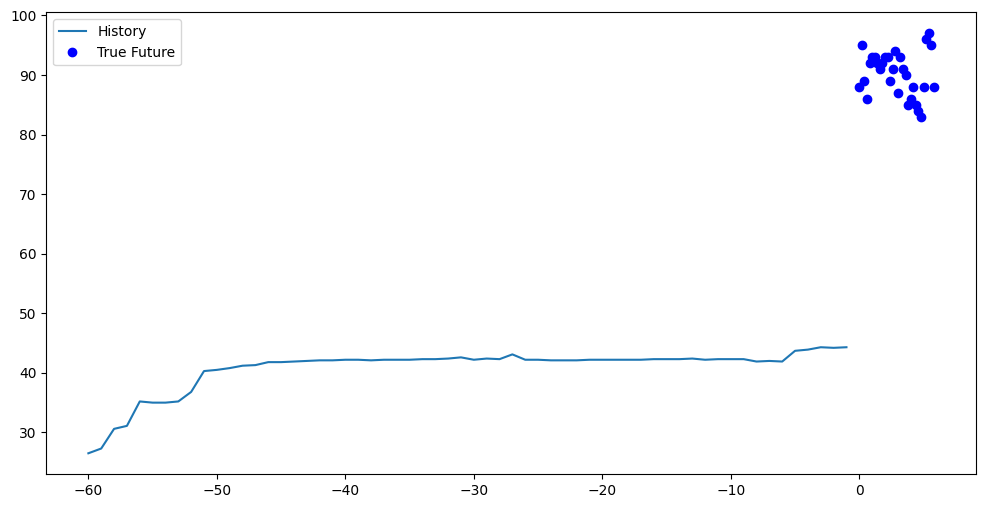

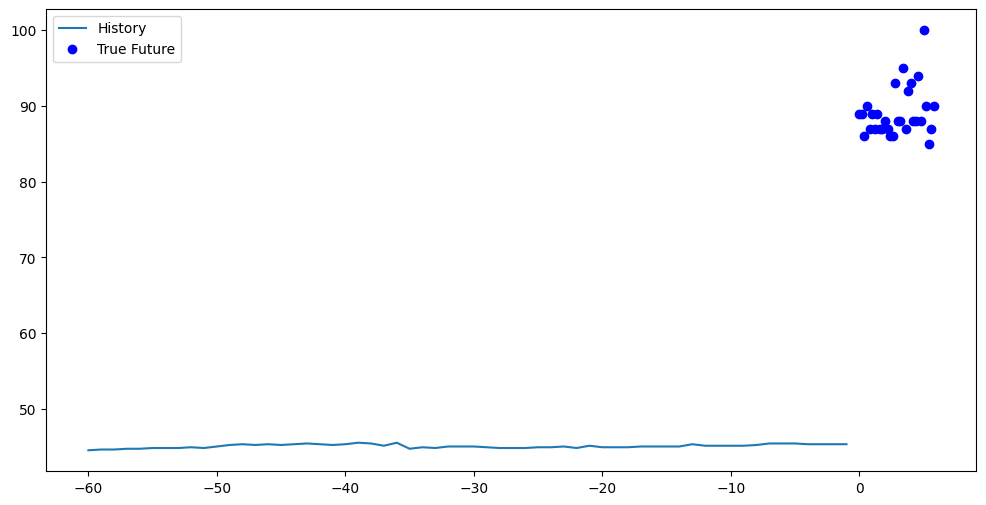

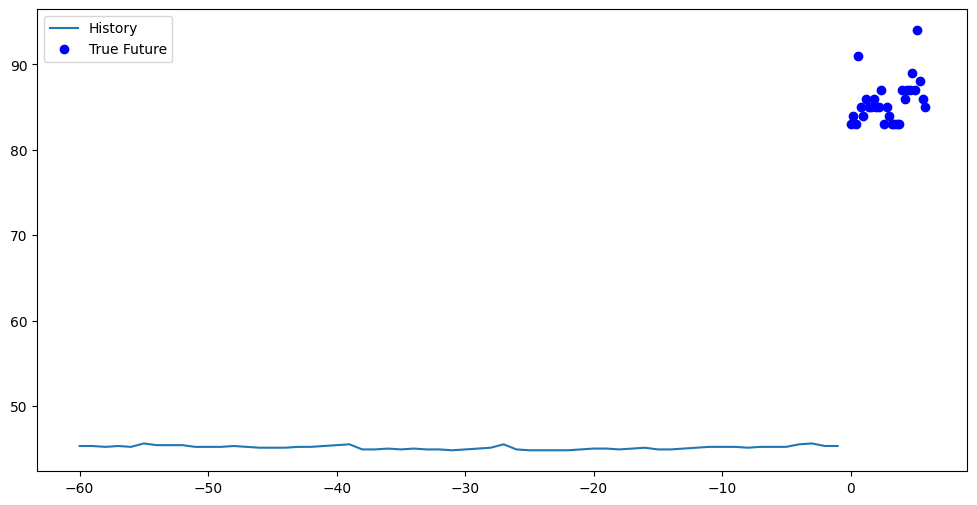

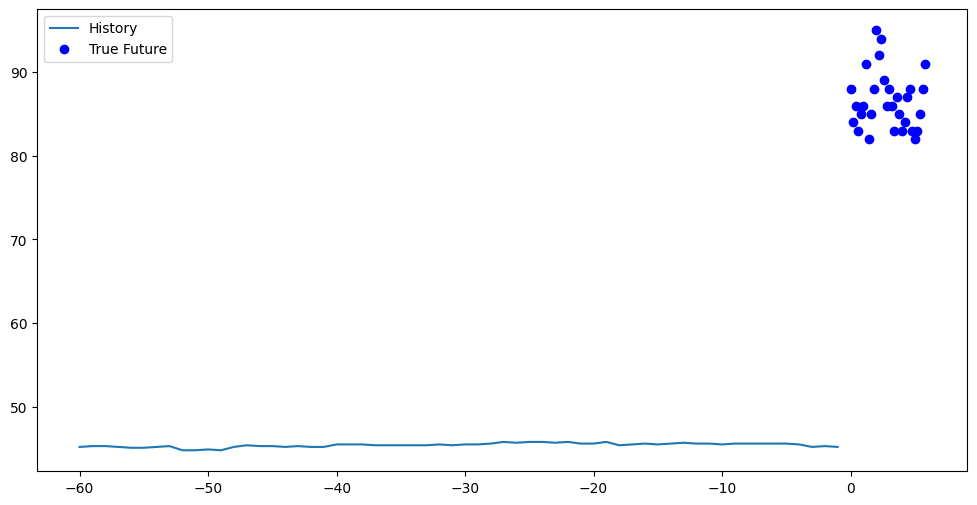

In [29]:
for x, y in val_data.take(4):
  #print(x[0])
  step_plot(x[0], 0, y[0], np.array([0]))

Модель будет состоять из двух слоёв LSTM. Наконец, поскольку выполняется 30 прогноза, выход слой насчитывает 30 нейрона.

In [30]:
def plot_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Первая LSTM модель

In [31]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
model1.add(tf.keras.layers.LSTM(16, activation='relu'))
model1.add(tf.keras.layers.Dense(30, activation='relu'))
model1.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [32]:
for x, y in val_data.take(1):
  print (model1.predict(x).shape)

10/10 [==============================] - 1s 11ms/step
(300, 30)


In [33]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [34]:
model1_history = model1.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 23s 99ms/step - loss: 307.7635 - val_loss: 62.8492
Epoch 2/10
200/200 [==============================] - 19s 95ms/step - loss: 283.3832 - val_loss: 56.7036
Epoch 3/10
200/200 [==============================] - 19s 93ms/step - loss: 41.6675 - val_loss: 66.9464
Epoch 4/10
200/200 [==============================] - 20s 98ms/step - loss: 73.9439 - val_loss: 90.3553
Epoch 5/10
200/200 [==============================] - 18s 92ms/step - loss: 70.8595 - val_loss: 74.0714
Epoch 6/10
200/200 [==============================] - 19s 95ms/step - loss: 42.5903 - val_loss: 70.8247
Epoch 7/10
200/200 [==============================] - 19s 95ms/step - loss: 41.9406 - val_loss: 70.5009
Epoch 8/10
200/200 [==============================] - 18s 91ms/step - loss: 41.7892 - val_loss: 71.1599
Epoch 9/10
200/200 [==============================] - 19s 96ms/step - loss: 41.6571 - val_loss: 71.0579
Epoch 10/10
200/200 [==============================] - 18s 91m

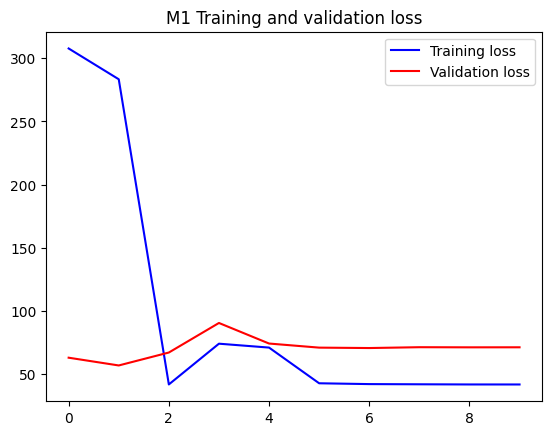

In [35]:
plot_history(model1_history, 'M1 Training and validation loss')

10/10 [==============================] - 0s 19ms/step


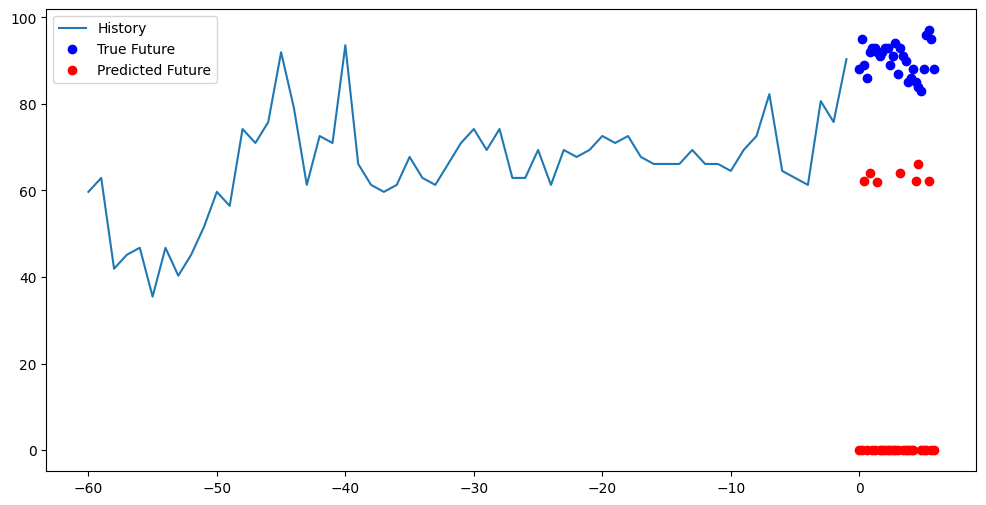

10/10 [==============================] - 0s 17ms/step


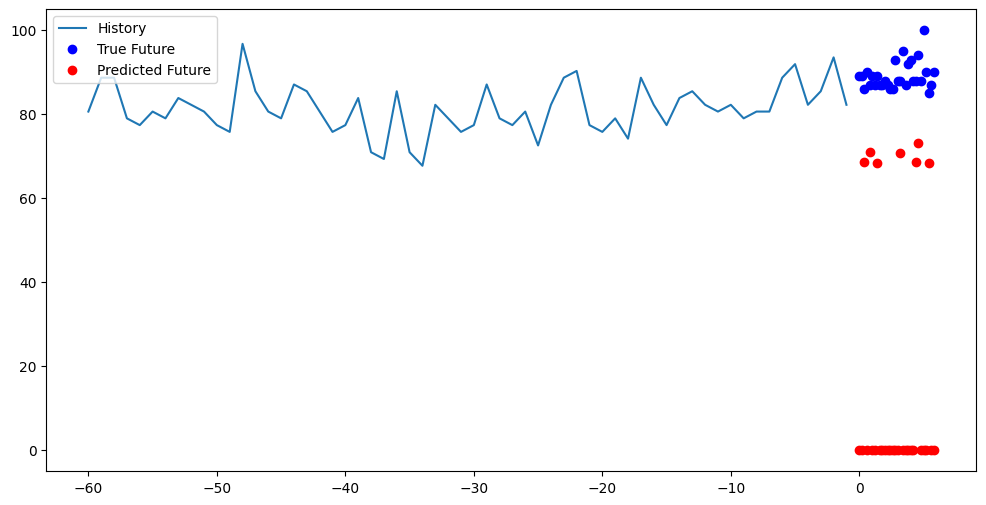

10/10 [==============================] - 0s 18ms/step


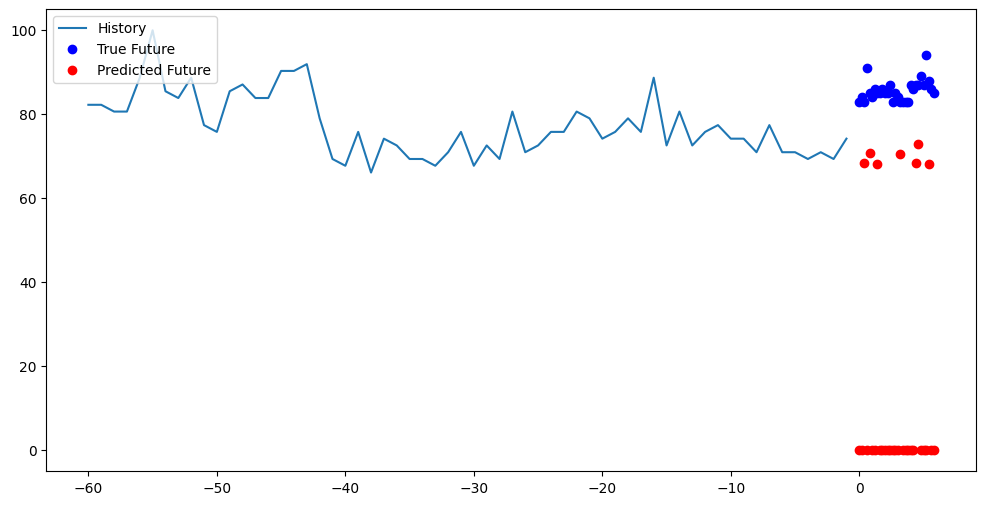

In [38]:
for x, y in val_data.take(3):
  step_plot(x[0], 4, y[0], model1.predict(x)[0])

Расширенная модель

In [39]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 128)           71168     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 30)               

In [40]:
for x, y in val_data.take(1):
  print (model.predict(x).shape)

10/10 [==============================] - 1s 35ms/step
(300, 30)


In [41]:
EVALUATION_INTERVAL = 100
EPOCHS = 25

In [42]:
model_history = model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50)

Epoch 1/25
100/100 [==============================] - 70s 640ms/step - loss: 54.9375 - val_loss: 86.4594
Epoch 2/25
100/100 [==============================] - 65s 647ms/step - loss: 52.0932 - val_loss: 86.7155
Epoch 3/25
100/100 [==============================] - 64s 645ms/step - loss: 52.3516 - val_loss: 86.8251
Epoch 4/25
100/100 [==============================] - 64s 640ms/step - loss: 55.4587 - val_loss: 86.7478
Epoch 5/25
100/100 [==============================] - 63s 626ms/step - loss: 52.1298 - val_loss: 86.5919
Epoch 6/25
100/100 [==============================] - 64s 642ms/step - loss: 51.9643 - val_loss: 86.1984
Epoch 7/25
100/100 [==============================] - 65s 648ms/step - loss: 50.9181 - val_loss: 86.3585
Epoch 8/25
100/100 [==============================] - 63s 632ms/step - loss: 51.6895 - val_loss: 86.0416
Epoch 9/25
100/100 [==============================] - 64s 643ms/step - loss: 51.9238 - val_loss: 86.0995
Epoch 10/25
100/100 [==============================] - 

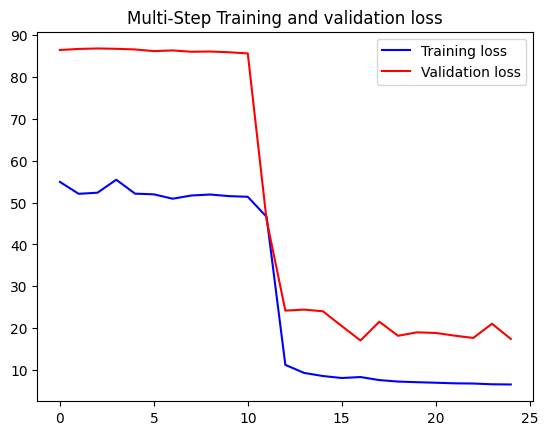

In [43]:
plot_history(model_history, 'Multi-Step Training and validation loss')

10/10 [==============================] - 0s 35ms/step


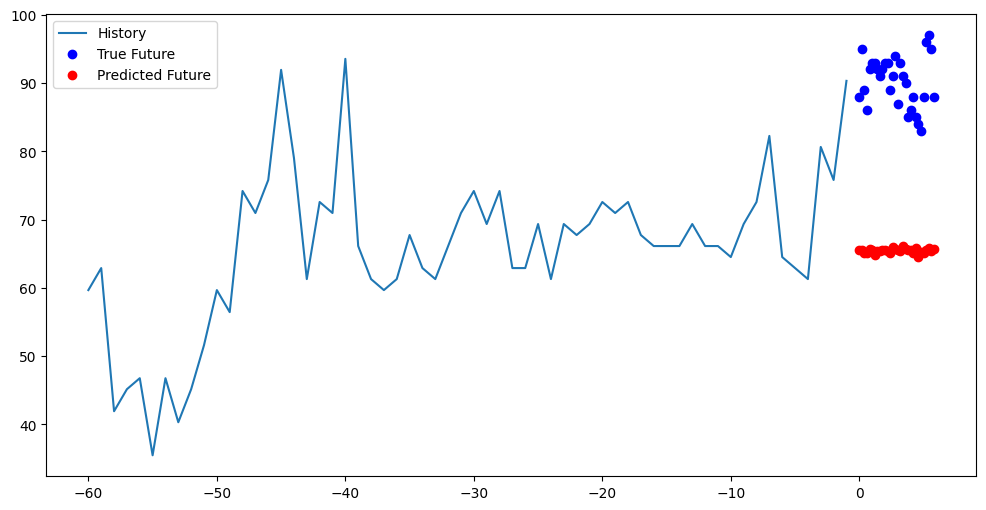

10/10 [==============================] - 0s 40ms/step


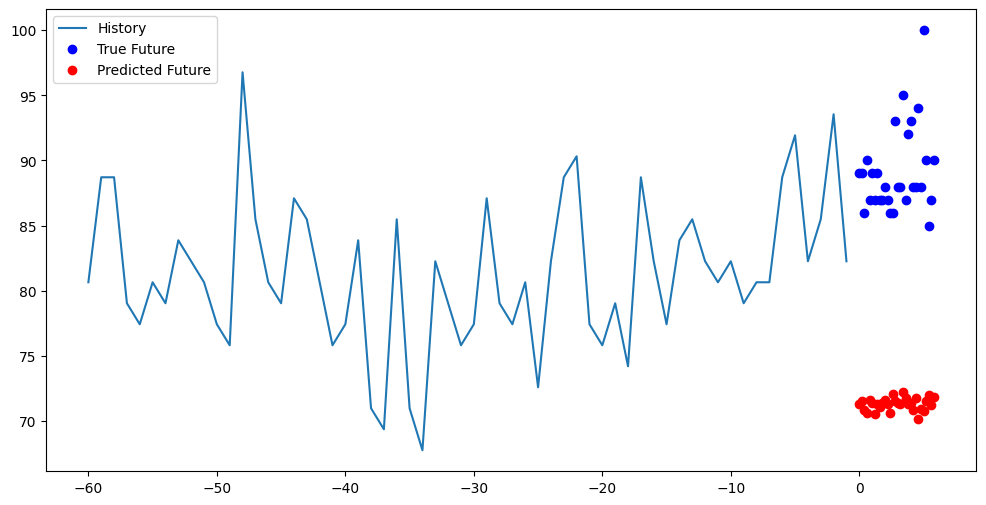

10/10 [==============================] - 0s 37ms/step


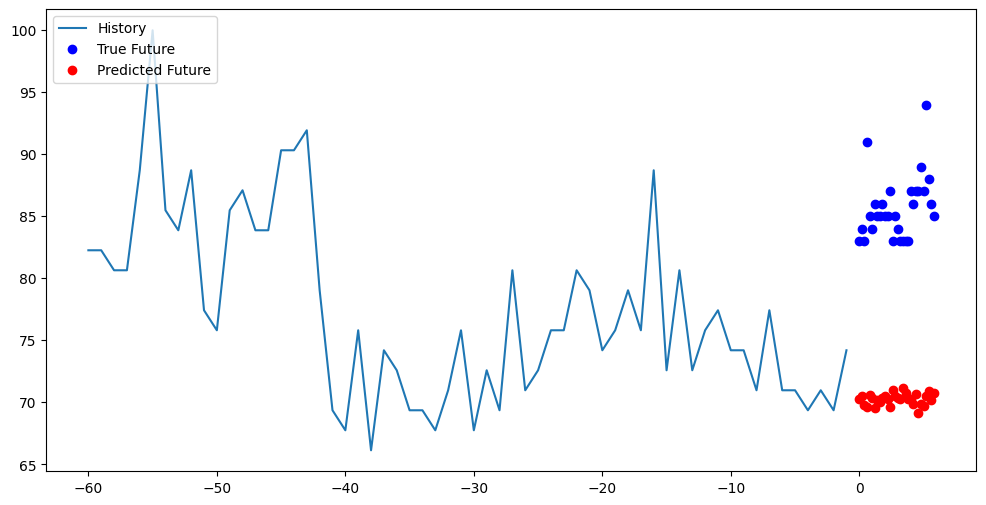

In [45]:
for x, y in val_data.take(3):
  step_plot(x[0],  4,y[0], model.predict(x)[0])

GRU модель

In [46]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.GRU(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.GRU(32, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.Dense(16))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(30, activation='relu'))
model2.compile(optimizer='adam', loss='mae')
for x, y in val_data.take(1):
  print (model2.predict(x).shape)



10/10 [==============================] - 1s 20ms/step
(300, 30)


In [47]:
EVALUATION_INTERVAL = 100
EPOCHS = 25

Epoch 1/25
100/100 [==============================] - 43s 383ms/step - loss: 33.6344 - val_loss: 43.6834
Epoch 2/25
100/100 [==============================] - 41s 407ms/step - loss: 14.9466 - val_loss: 22.4455
Epoch 3/25
100/100 [==============================] - 36s 363ms/step - loss: 11.6173 - val_loss: 20.9571
Epoch 4/25
100/100 [==============================] - 36s 365ms/step - loss: 10.5535 - val_loss: 19.5906
Epoch 5/25
100/100 [==============================] - 35s 351ms/step - loss: 9.9564 - val_loss: 19.6008
Epoch 6/25
100/100 [==============================] - 37s 368ms/step - loss: 9.6221 - val_loss: 17.8134
Epoch 7/25
100/100 [==============================] - 37s 368ms/step - loss: 9.3303 - val_loss: 14.8594
Epoch 8/25
100/100 [==============================] - 36s 356ms/step - loss: 9.1868 - val_loss: 16.2110
Epoch 9/25
100/100 [==============================] - 37s 369ms/step - loss: 9.0897 - val_loss: 17.7844
Epoch 10/25
100/100 [==============================] - 37s 3

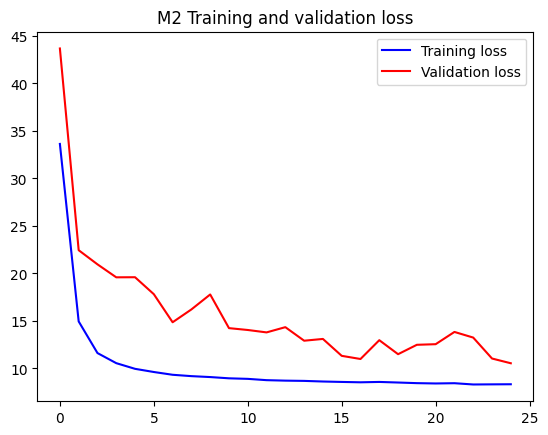

In [48]:
model_history = model2.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50)
plot_history(model_history, 'M2 Training and validation loss')


Подготовим модели для каждого параметра

In [61]:
EVALUATION_INTERVAL =  50
EPOCHS = 25
STEP = 3

1) Загрузка виртуальной памяти

In [62]:
x_train, y_train = multivariate_data(X, Y[:, 0], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 0], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_v_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_v_data = train_data_v_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_v_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_v_data = val_data_v_data.batch(BATCH_SIZE).repeat()

In [63]:
model_v_data = tf.keras.models.Sequential()
model_v_data.add(tf.keras.layers.LSTM(128, return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
#model_v_data.add(tf.keras.layers.Dropout(0.2))
model_v_data.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_v_data.add(tf.keras.layers.LSTM(32, activation= 'relu'))
model_v_data.add(tf.keras.layers.Dropout(0.2))
model_v_data.add(tf.keras.layers.Dense(32, activation='relu'))
model_v_data.add(tf.keras.layers.Dropout(0.2))
model_v_data.add(tf.keras.layers.Dense(30, activation='relu'))
model_v_data.compile(optimizer='adam', loss='mse', metrics = 'mae')

In [64]:
model_history_v_data = model_v_data.fit(train_data_v_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_v_data,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 87s 1s/step - loss: 3639.4207 - mae: 56.3833 - val_loss: 910.9512 - val_mae: 25.1362
Epoch 2/25
50/50 [==============================] - 63s 1s/step - loss: 2120.8386 - mae: 38.8302 - val_loss: 254.3083 - val_mae: 10.4403
Epoch 3/25
50/50 [==============================] - 67s 1s/step - loss: 1135.8716 - mae: 26.8937 - val_loss: 120.9391 - val_mae: 9.9088
Epoch 4/25
50/50 [==============================] - 60s 1s/step - loss: 729.9075 - mae: 21.2949 - val_loss: 88.5181 - val_mae: 8.9202
Epoch 5/25
50/50 [==============================] - 63s 1s/step - loss: 562.8320 - mae: 18.8251 - val_loss: 93.1493 - val_mae: 9.2545
Epoch 6/25
50/50 [==============================] - 66s 1s/step - loss: 448.6481 - mae: 16.8391 - val_loss: 61.8467 - val_mae: 7.6279
Epoch 7/25
50/50 [==============================] - 63s 1s/step - loss: 395.3793 - mae: 15.8432 - val_loss: 87.8137 - val_mae: 9.2101
Epoch 8/25
50/50 [==============================] - 63

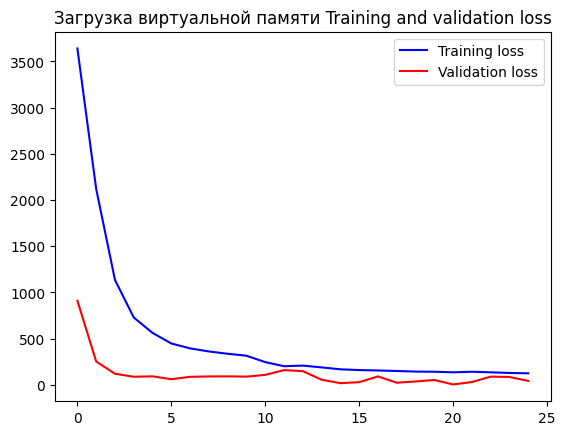

In [65]:
plot_history(model_history_v_data, 'Загрузка виртуальной памяти Training and validation loss')

10/10 [==============================] - 2s 64ms/step


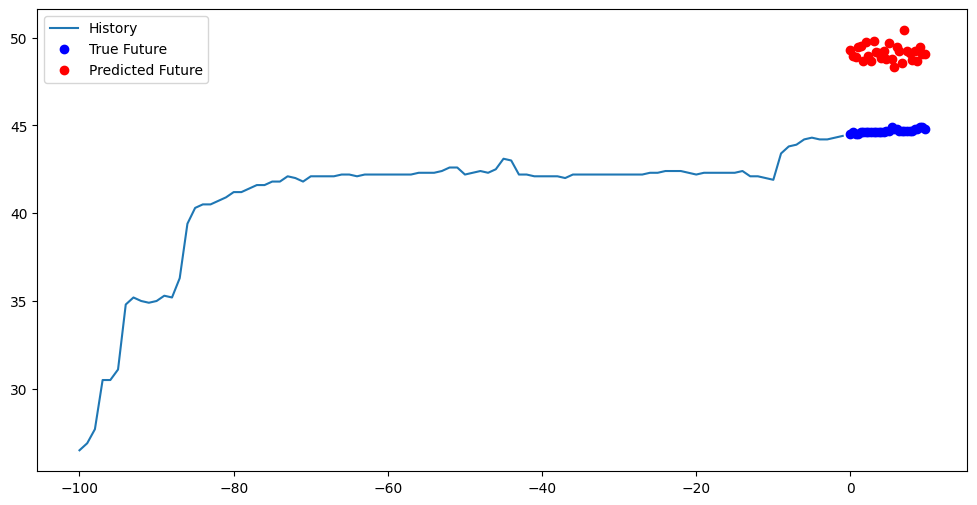

10/10 [==============================] - 1s 62ms/step


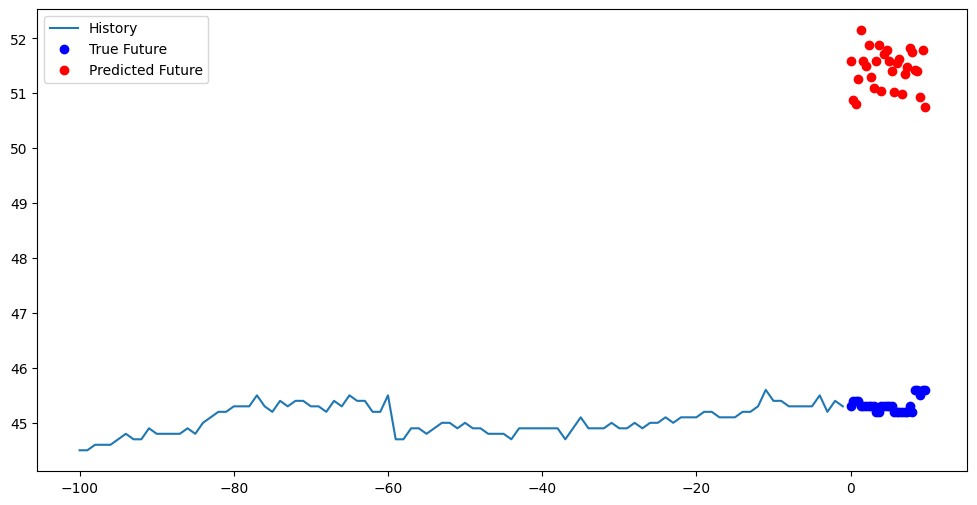

10/10 [==============================] - 1s 63ms/step


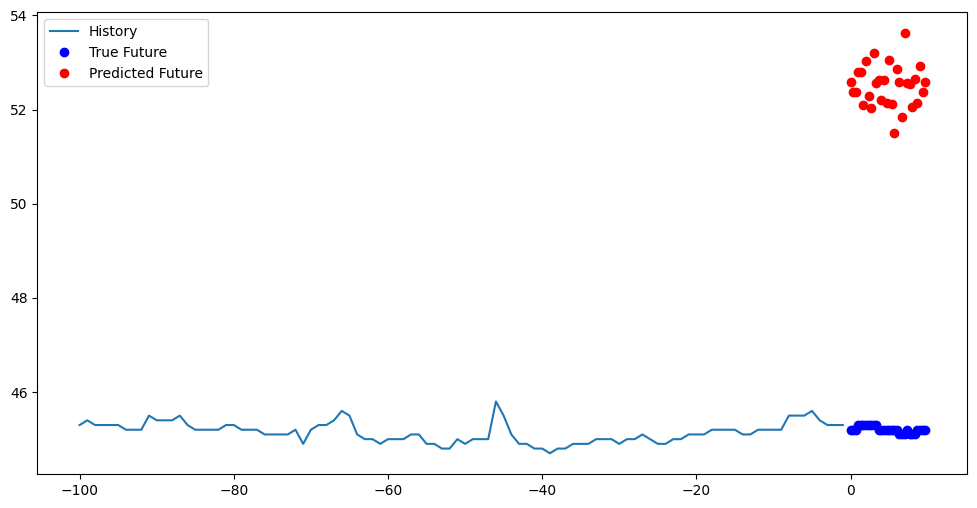

10/10 [==============================] - 1s 113ms/step


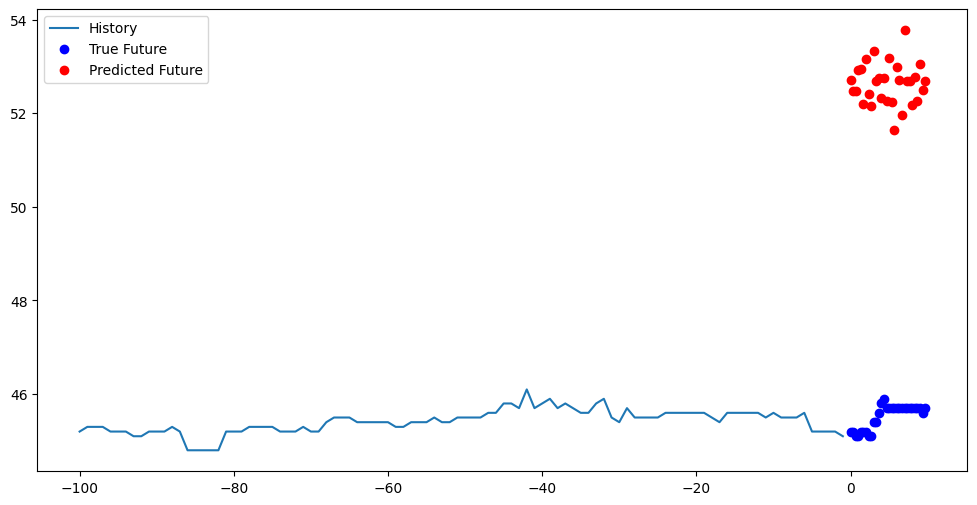

10/10 [==============================] - 1s 109ms/step


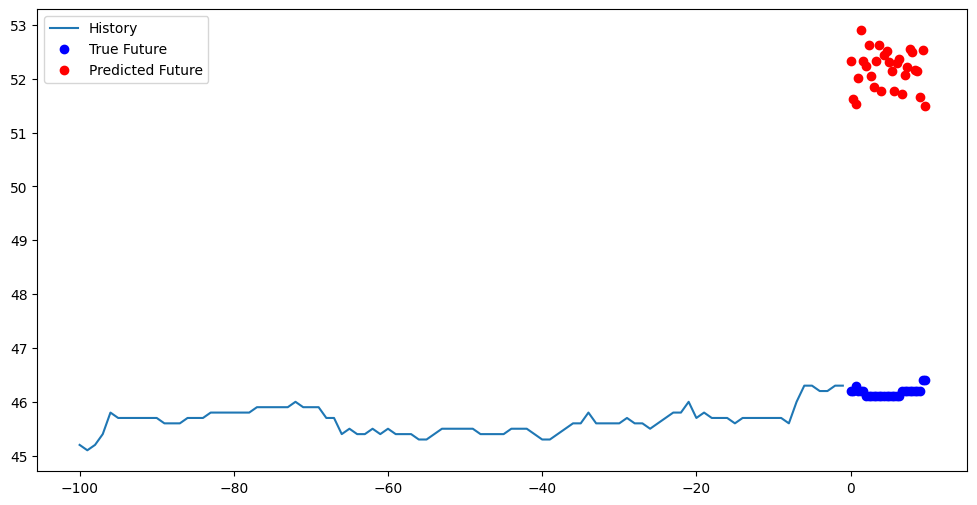

10/10 [==============================] - 1s 62ms/step


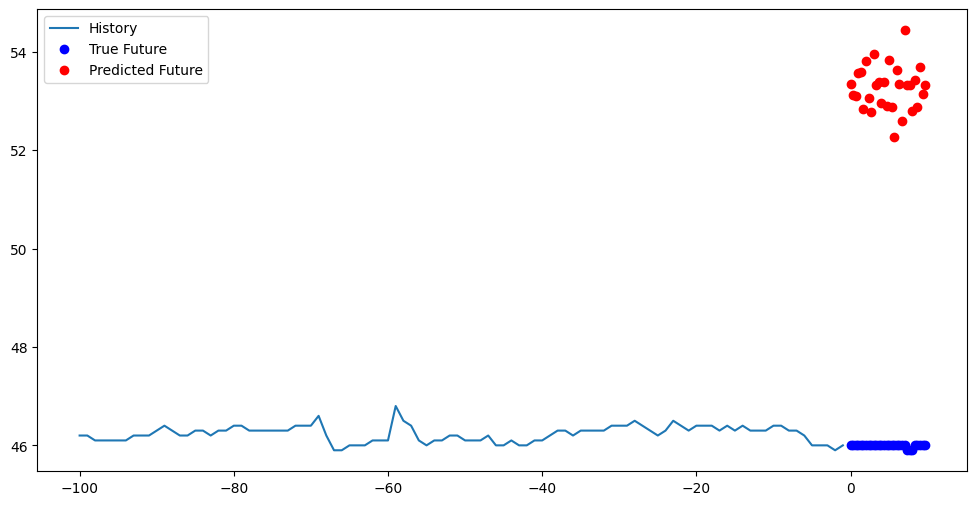

In [66]:
for x, y in val_data_v_data.take(6):
  step_plot(x[0], 0,  y[0], model_v_data.predict(x)[0])

In [67]:
model_v_data.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 100, 128)          71168     
                                                                 
 lstm_15 (LSTM)              (None, 100, 64)           49408     
                                                                 
 lstm_16 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 30)               

In [68]:
model_v_data.save('Model_memory_recovery.h5')
print('Model Saved!')

model_v_data.save_weights('Model_memory_recovery_Weights')
print('Model Saved!')


Model Saved!
Model Saved!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2) Физическая нагрузка на память

In [69]:
x_train, y_train = multivariate_data(X, Y[:, 1], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 1], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_f_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_f_data = train_data_f_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_f_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_f_data = val_data_f_data.batch(BATCH_SIZE).repeat()

In [70]:
model_f_data = tf.keras.models.Sequential()
model_f_data.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))

model_f_data.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_f_data.add(tf.keras.layers.LSTM(32, activation='relu'))
model_f_data.add(tf.keras.layers.Dropout(0.2))
model_f_data.add(tf.keras.layers.Dense(32, activation='relu'))
model_f_data.add(tf.keras.layers.Dropout(0.2))
model_f_data.add(tf.keras.layers.Dense(30, activation='relu'))
model_f_data.compile(optimizer='adam',  loss='mse', metrics = 'mae')

In [71]:
model_f_data.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 100, 128)          71168     
                                                                 
 lstm_18 (LSTM)              (None, 100, 64)           49408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 30)               

In [72]:
model_history_f_data = model_f_data.fit(train_data_f_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_f_data,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 70s 1s/step - loss: 3474.1453 - mae: 52.3437 - val_loss: 708.9578 - val_mae: 23.4427
Epoch 2/25
50/50 [==============================] - 65s 1s/step - loss: 1536.9469 - mae: 31.5847 - val_loss: 313.5914 - val_mae: 16.9606
Epoch 3/25
50/50 [==============================] - 64s 1s/step - loss: 698.2104 - mae: 20.4252 - val_loss: 554.1177 - val_mae: 23.4144
Epoch 4/25
50/50 [==============================] - 65s 1s/step - loss: 459.1675 - mae: 16.3942 - val_loss: 1005.0360 - val_mae: 31.6000
Epoch 5/25
50/50 [==============================] - 63s 1s/step - loss: 355.7115 - mae: 14.4417 - val_loss: 1113.3235 - val_mae: 33.2811
Epoch 6/25
50/50 [==============================] - 59s 1s/step - loss: 295.9500 - mae: 13.0798 - val_loss: 740.9291 - val_mae: 27.1479
Epoch 7/25
50/50 [==============================] - 67s 1s/step - loss: 262.6619 - mae: 12.2661 - val_loss: 555.1232 - val_mae: 23.4981
Epoch 8/25
50/50 [==========================

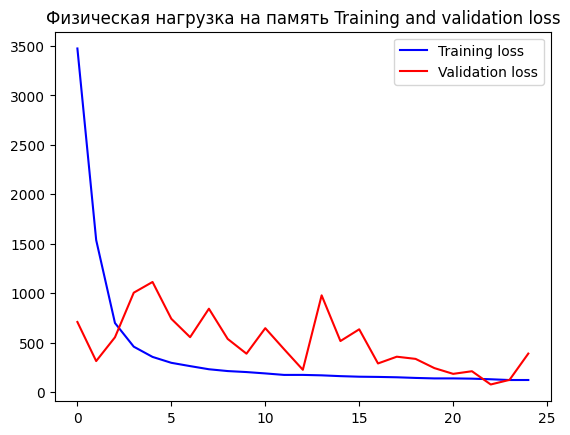

In [73]:
plot_history(model_history_f_data, 'Физическая нагрузка на память Training and validation loss')

10/10 [==============================] - 2s 61ms/step


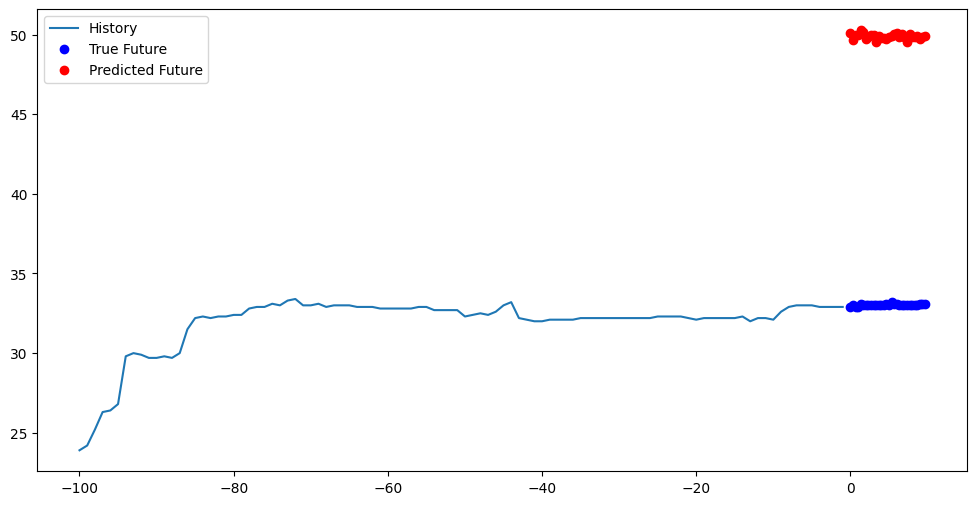

10/10 [==============================] - 1s 61ms/step


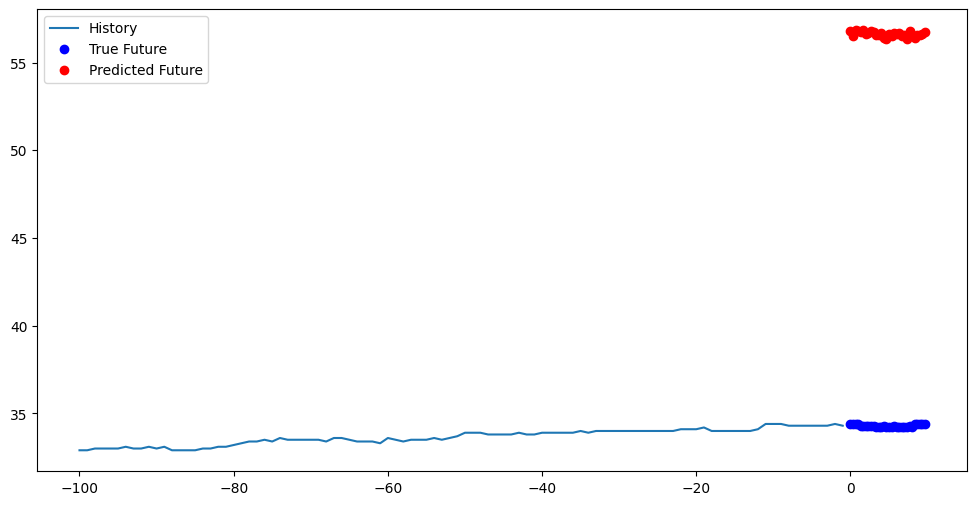

10/10 [==============================] - 1s 61ms/step


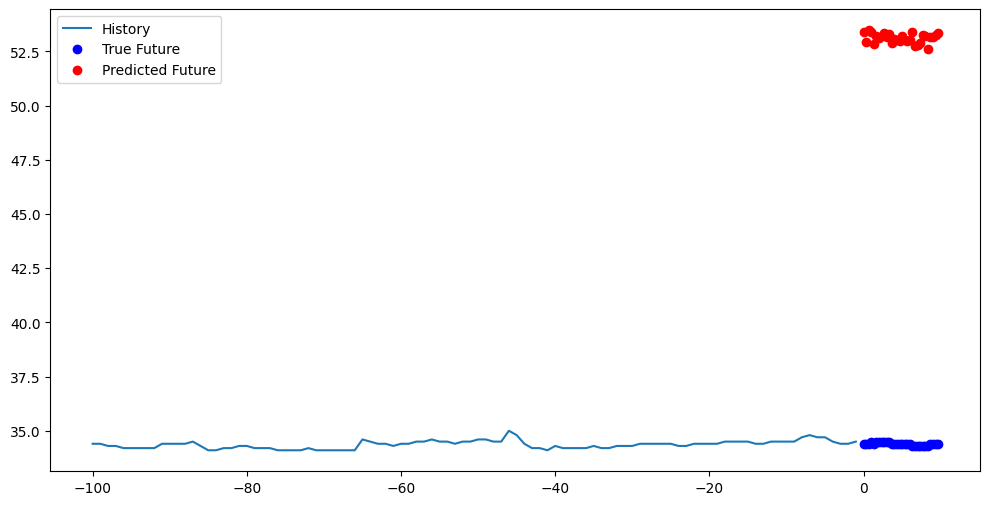

10/10 [==============================] - 1s 59ms/step


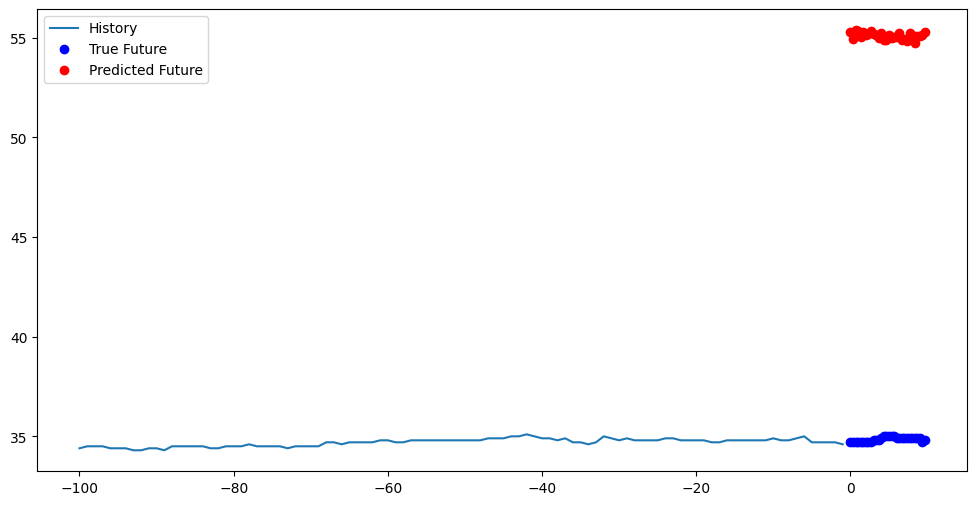

10/10 [==============================] - 1s 61ms/step


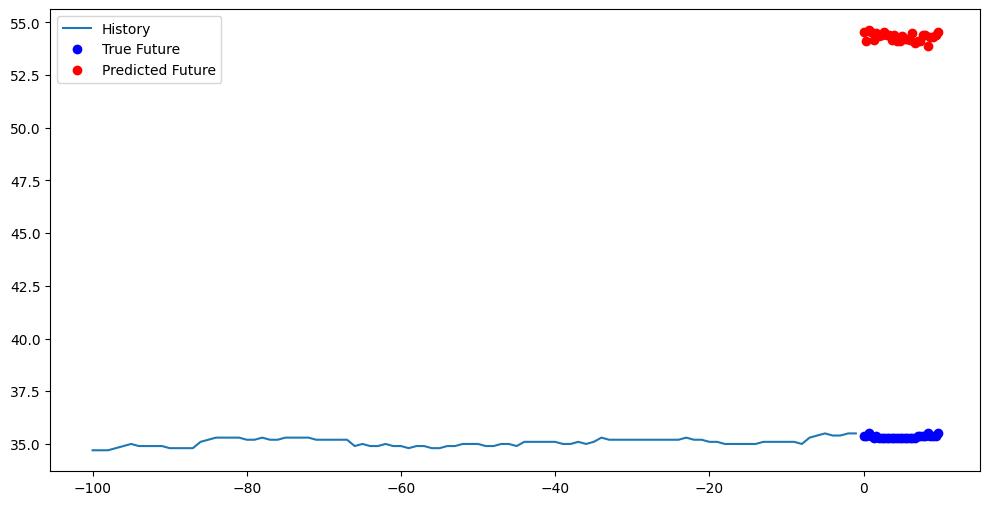

10/10 [==============================] - 1s 61ms/step


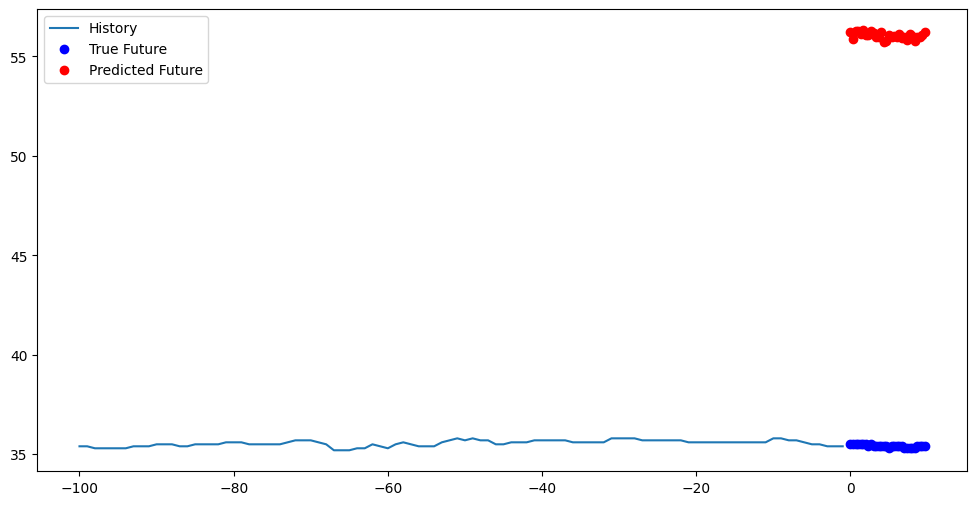

In [74]:
for x, y in val_data_f_data.take(6):
  step_plot(x[0], 1,  y[0], model_f_data.predict(x)[0])

In [75]:
model_v_data.save('Model_load on memory.h5')
print('Model Saved!')

model_v_data.save_weights('Model_load on memory_Weights')
print('Model Saved!')

Model Saved!
Model Saved!


3) Использование файла подкачки

In [76]:
x_train, y_train = multivariate_data(X, Y[:, 2], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 2], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_f_podk = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_f_podk = train_data_f_podk.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_f_podk = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_f_podk = val_data_f_podk.batch(BATCH_SIZE).repeat()

In [77]:
model_f_podk = tf.keras.models.Sequential()
model_f_podk.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
model_f_podk.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_f_podk.add(tf.keras.layers.LSTM(32, activation='relu'))
model_f_podk.add(tf.keras.layers.Dropout(0.2))
model_f_podk.add(tf.keras.layers.Dense(32, activation='relu'))
model_f_podk.add(tf.keras.layers.Dropout(0.2))
model_f_podk.add(tf.keras.layers.Dense(30, activation='relu'))
model_f_podk.compile(optimizer='adam', loss='mse', metrics = 'mae')

In [78]:
model_history_f_podk = model_f_podk.fit(train_data_f_podk, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_f_podk,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 72s 1s/step - loss: 55.9342 - mae: 6.3181 - val_loss: 38.8105 - val_mae: 5.3186
Epoch 2/25
50/50 [==============================] - 62s 1s/step - loss: 20.3915 - mae: 3.4218 - val_loss: 28.3199 - val_mae: 5.2744
Epoch 3/25
50/50 [==============================] - 63s 1s/step - loss: 10.0419 - mae: 2.3461 - val_loss: 23.4770 - val_mae: 4.8382
Epoch 4/25
50/50 [==============================] - 64s 1s/step - loss: 7.8317 - mae: 2.0504 - val_loss: 18.8153 - val_mae: 4.3316
Epoch 5/25
50/50 [==============================] - 63s 1s/step - loss: 6.6814 - mae: 1.8829 - val_loss: 16.7970 - val_mae: 4.0922
Epoch 6/25
50/50 [==============================] - 63s 1s/step - loss: 5.9669 - mae: 1.7666 - val_loss: 16.6668 - val_mae: 4.0770
Epoch 7/25
50/50 [==============================] - 61s 1s/step - loss: 5.5208 - mae: 1.6952 - val_loss: 16.1778 - val_mae: 4.0180
Epoch 8/25
50/50 [==============================] - 63s 1s/step - loss: 4.8098 -

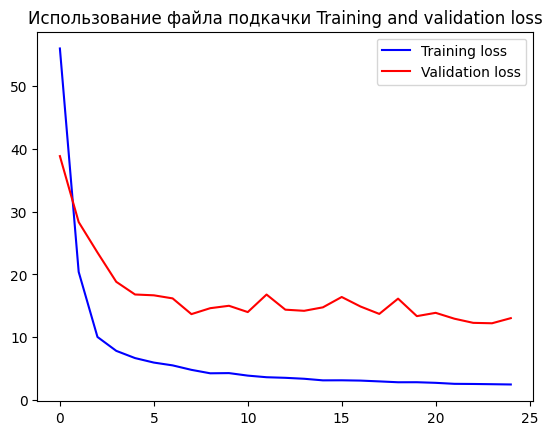

In [79]:
plot_history(model_history_f_podk, 'Использование файла подкачки Training and validation loss')

10/10 [==============================] - 2s 63ms/step


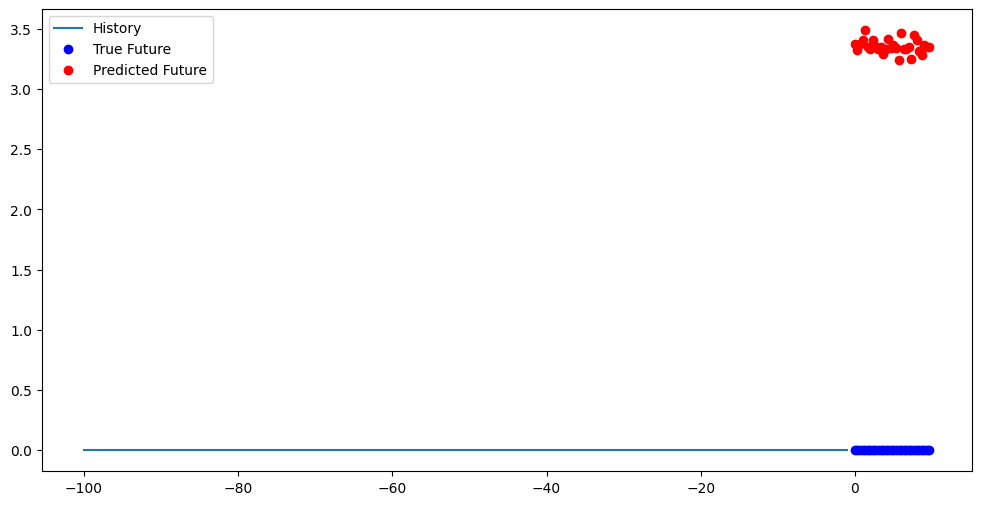

10/10 [==============================] - 1s 105ms/step


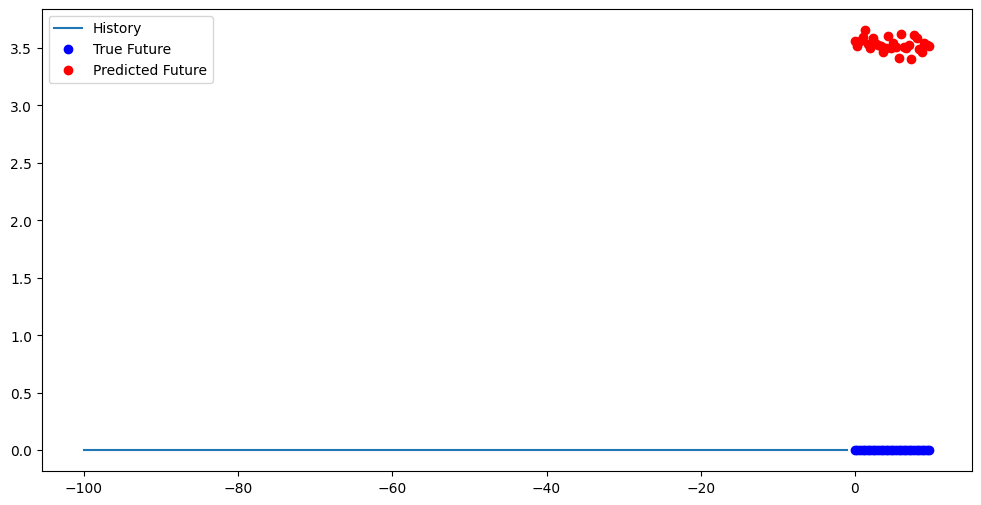

10/10 [==============================] - 1s 86ms/step


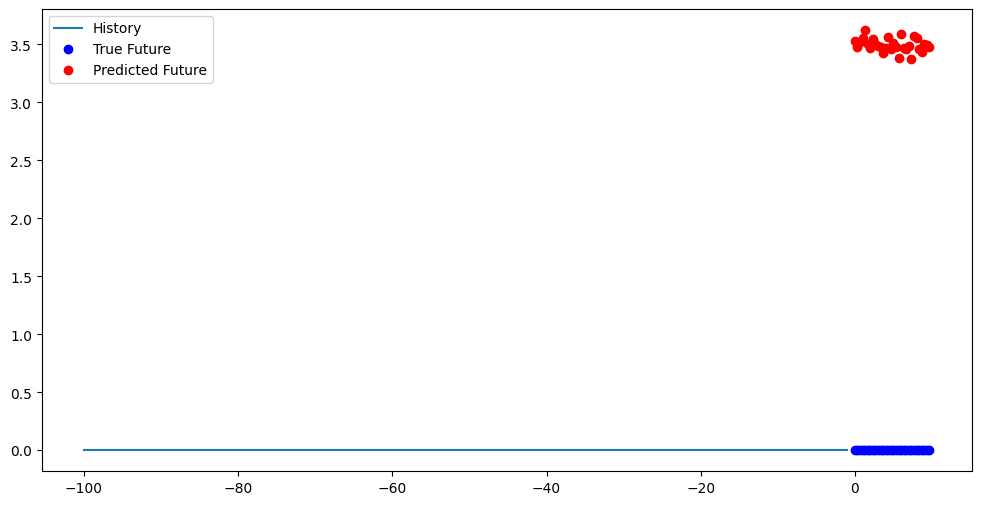

10/10 [==============================] - 1s 60ms/step


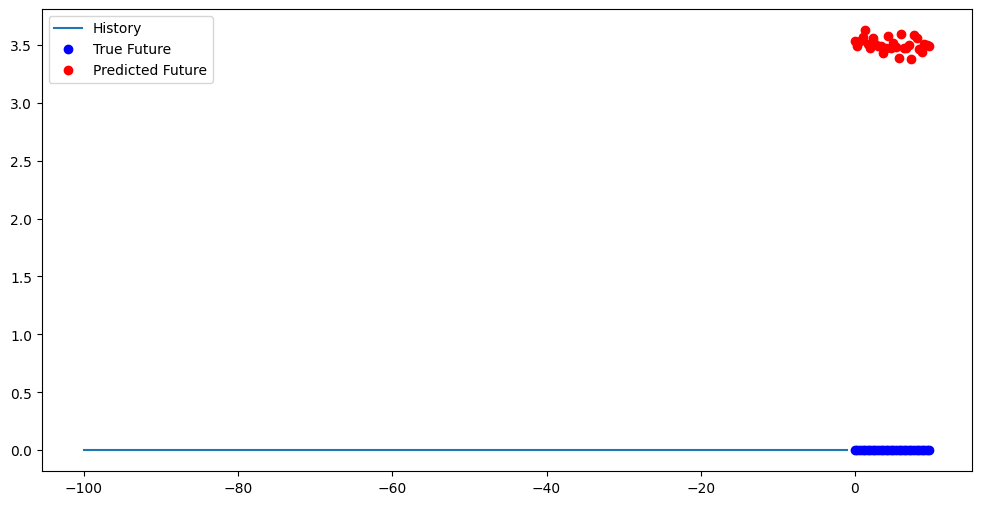

10/10 [==============================] - 1s 61ms/step


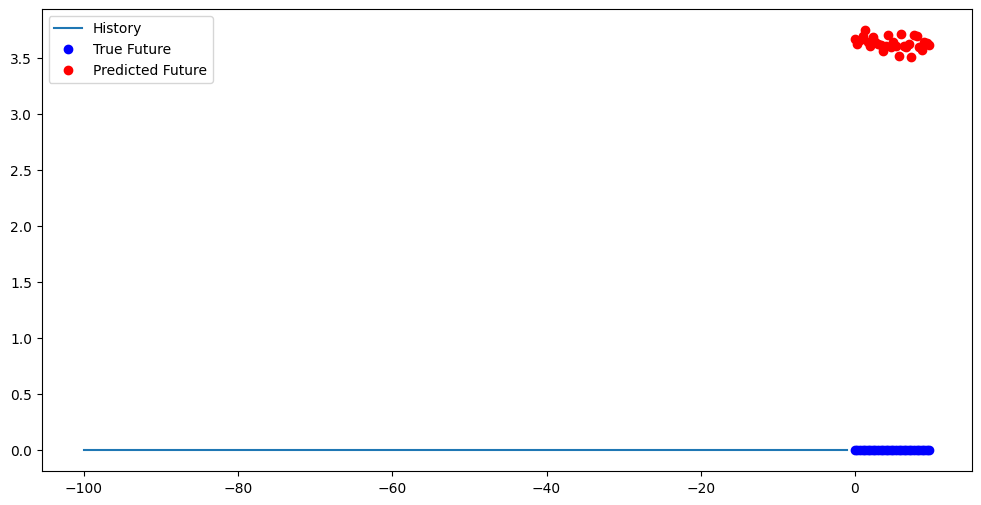

10/10 [==============================] - 1s 62ms/step


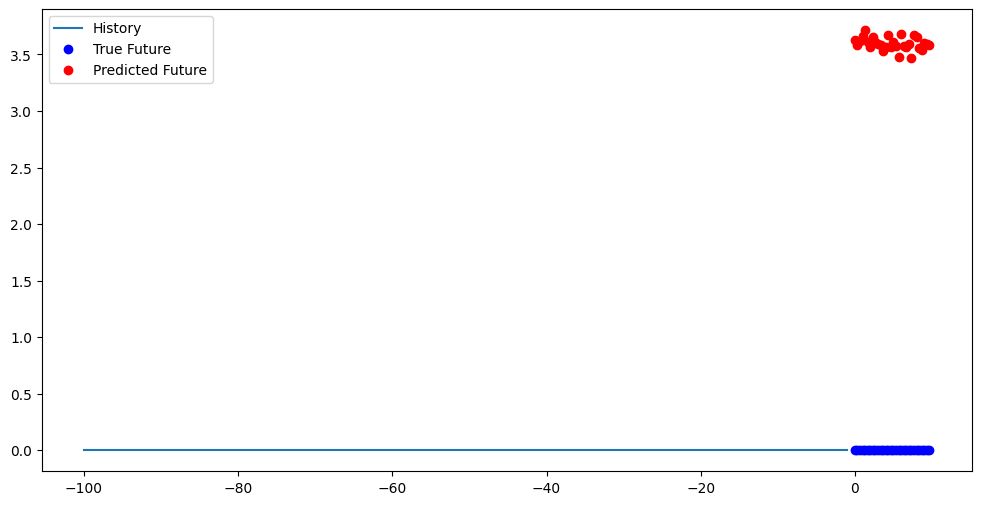

In [80]:
for x, y in val_data_f_podk.take(6):
  step_plot(x[0], 2,  y[0], model_f_podk.predict(x)[0])

In [81]:
model_v_data.save('Model_Swap file usage.h5')
print('Model Saved!')

model_v_data.save_weights('Model_Swap file usage_Weights')
print('Model Saved!')

Model Saved!
Model Saved!


4) Общая загрузка ЦП

In [82]:
x_train, y_train = multivariate_data(X, Y[:, 3], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 3], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_z_cpu = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_z_cpu = train_data_z_cpu.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_z_cpu = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_z_cpu = val_data_z_cpu.batch(BATCH_SIZE).repeat()

In [83]:
model_z_cpu = tf.keras.models.Sequential()
model_z_cpu.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))

model_z_cpu.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_z_cpu.add(tf.keras.layers.LSTM(32, activation='relu'))
model_z_cpu.add(tf.keras.layers.Dropout(0.2))
model_z_cpu.add(tf.keras.layers.Dense(32, activation='relu'))
model_z_cpu.add(tf.keras.layers.Dropout(0.2))
model_z_cpu.add(tf.keras.layers.Dense(30, activation='relu'))
model_z_cpu.compile(optimizer='adam', loss='mse', metrics = 'mae')

In [84]:
model_history_z_cpu = model_z_cpu.fit(train_data_z_cpu, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_z_cpu,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 70s 1s/step - loss: 2532456.5000 - mae: 315.0645 - val_loss: 5861151.5000 - val_mae: 1327.3309
Epoch 2/25
50/50 [==============================] - 64s 1s/step - loss: 87252.2734 - mae: 52.7127 - val_loss: 2158.9270 - val_mae: 44.1098
Epoch 3/25
50/50 [==============================] - 63s 1s/step - loss: 923.1519 - mae: 23.8966 - val_loss: 2149.1995 - val_mae: 43.9899
Epoch 4/25
50/50 [==============================] - 64s 1s/step - loss: 924.1367 - mae: 23.8987 - val_loss: 2148.3945 - val_mae: 43.9842
Epoch 5/25
50/50 [==============================] - 63s 1s/step - loss: 922.9883 - mae: 23.8804 - val_loss: 2145.1392 - val_mae: 43.9494
Epoch 6/25
50/50 [==============================] - 63s 1s/step - loss: 921.7623 - mae: 23.8281 - val_loss: 2143.1931 - val_mae: 43.9104
Epoch 7/25
50/50 [==============================] - 59s 1s/step - loss: 912.5009 - mae: 23.7195 - val_loss: 2138.8098 - val_mae: 43.8648
Epoch 8/25
50/50 [===========

In [ ]:
plot_history(model_history_z_cpu, 'Общая загрузка ЦП Training and validation loss')

In [ ]:
for x, y in val_data_z_cpu.take(6):
  step_plot(x[0], 3,  y[0], model_z_cpu.predict(x)[0])

In [87]:
model_z_cpu.save('Model_CPU_load_file usage.h5')
print('Model Saved!')

model_z_cpu.save_weights('Model_CPU_load_file usage_Weights')
print('Model Saved!')

Model Saved!
Model Saved!
Model Saved!
Model Saved!


5) Температура ЦП

In [88]:
x_train, y_train = multivariate_data(X, Y[:, 4], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 4], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_t_cpu = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_t_cpu = train_data_t_cpu.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_t_cpu = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_t_cpu = val_data_t_cpu.batch(BATCH_SIZE).repeat()

In [91]:
model_t_cpu = tf.keras.models.Sequential()
model_t_cpu.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))

model_t_cpu.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_t_cpu.add(tf.keras.layers.LSTM(32, activation='relu'))
model_t_cpu.add(tf.keras.layers.Dropout(0.2))
model_t_cpu.add(tf.keras.layers.Dense(32, activation='relu'))
model_t_cpu.add(tf.keras.layers.Dropout(0.2))
model_t_cpu.add(tf.keras.layers.Dense(30, activation='relu'))
model_t_cpu.compile(optimizer='adam', loss='mape', metrics = 'mse')

In [92]:
model_history_t_cpu = model_t_cpu.fit(train_data_t_cpu, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_t_cpu,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 76s 1s/step - loss: 143.7937 - mse: 1140057.2500 - val_loss: 99.7527 - val_mse: 7592.4351
Epoch 2/25
50/50 [==============================] - 65s 1s/step - loss: 99.3118 - mse: 2863.7412 - val_loss: 99.0937 - val_mse: 7493.3096
Epoch 3/25
50/50 [==============================] - 63s 1s/step - loss: 65.9008 - mse: 1603.3191 - val_loss: 59.8419 - val_mse: 3038.7744
Epoch 4/25
50/50 [==============================] - 64s 1s/step - loss: 38.3481 - mse: 672.4797 - val_loss: 45.0207 - val_mse: 1594.0522
Epoch 5/25
50/50 [==============================] - 64s 1s/step - loss: 29.0347 - mse: 389.6417 - val_loss: 11.5507 - val_mse: 147.8561
Epoch 6/25
50/50 [==============================] - 63s 1s/step - loss: 26.8493 - mse: 337.2126 - val_loss: 33.5995 - val_mse: 889.7259
Epoch 7/25
50/50 [==============================] - 60s 1s/step - loss: 24.1260 - mse: 268.1121 - val_loss: 33.6757 - val_mse: 892.7446
Epoch 8/25
50/50 [===================

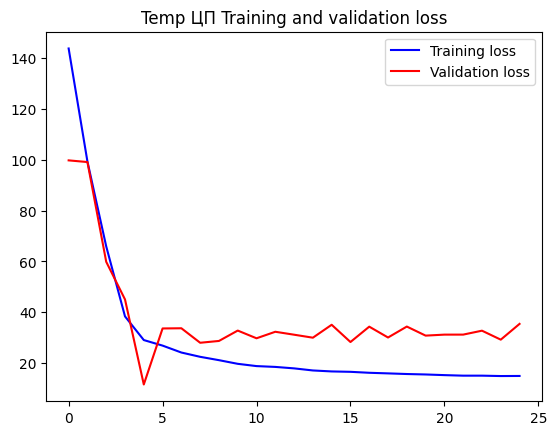

In [93]:
plot_history(model_history_t_cpu, 'Temp ЦП Training and validation loss')

10/10 [==============================] - 2s 59ms/step


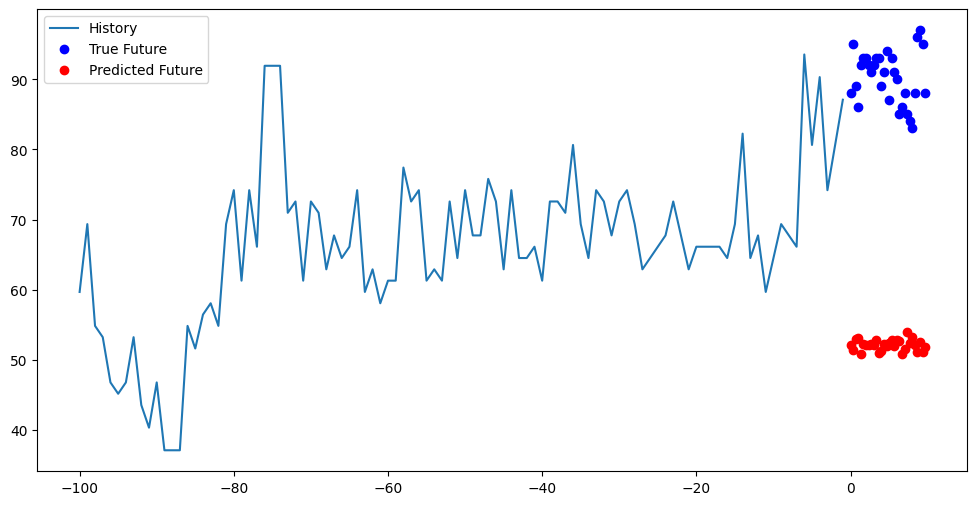

10/10 [==============================] - 1s 112ms/step


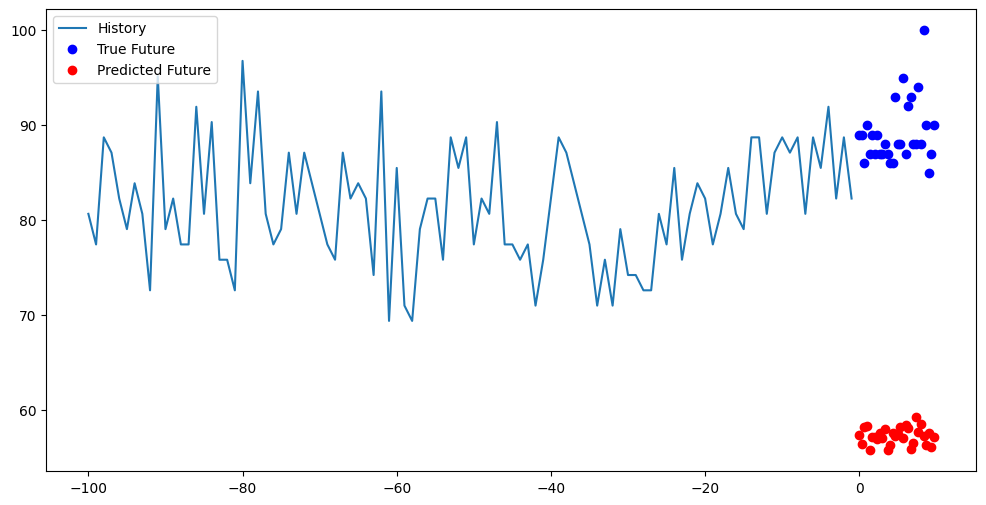

10/10 [==============================] - 1s 116ms/step


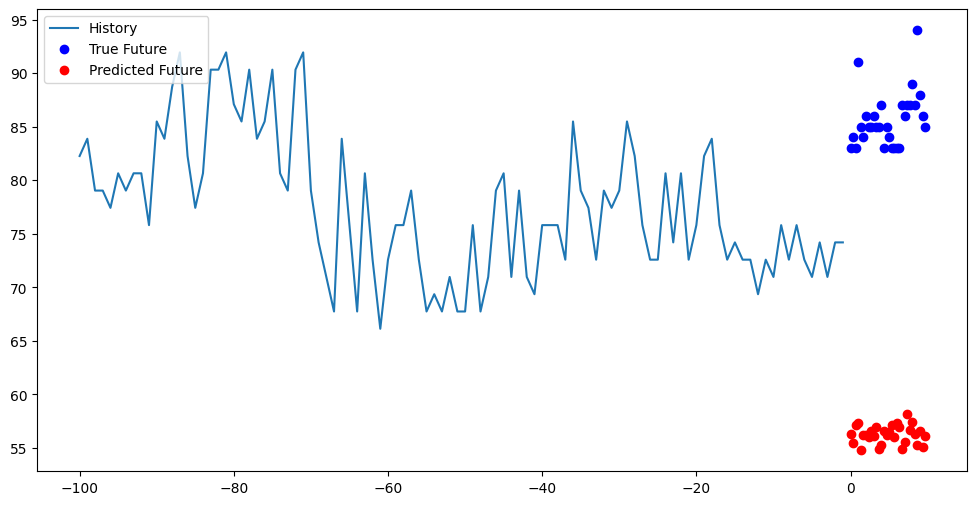

10/10 [==============================] - 1s 64ms/step


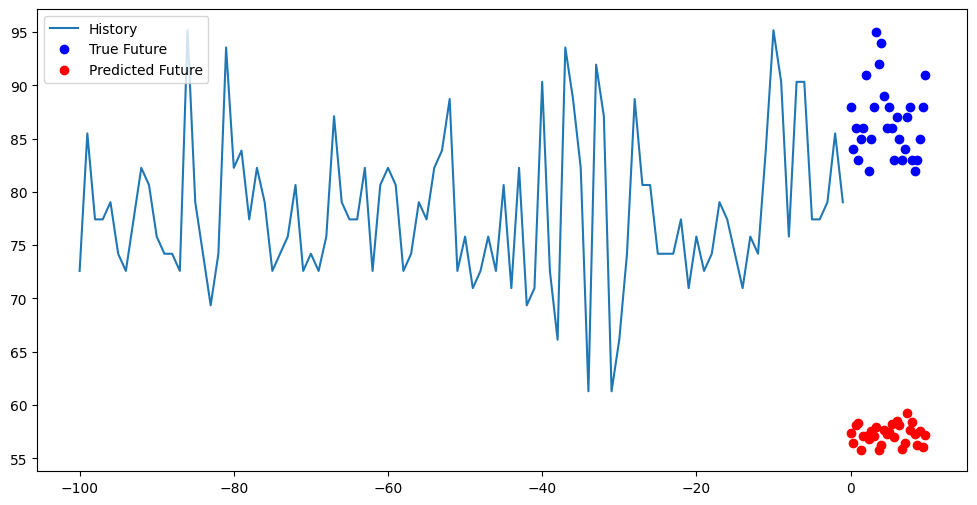

10/10 [==============================] - 1s 65ms/step


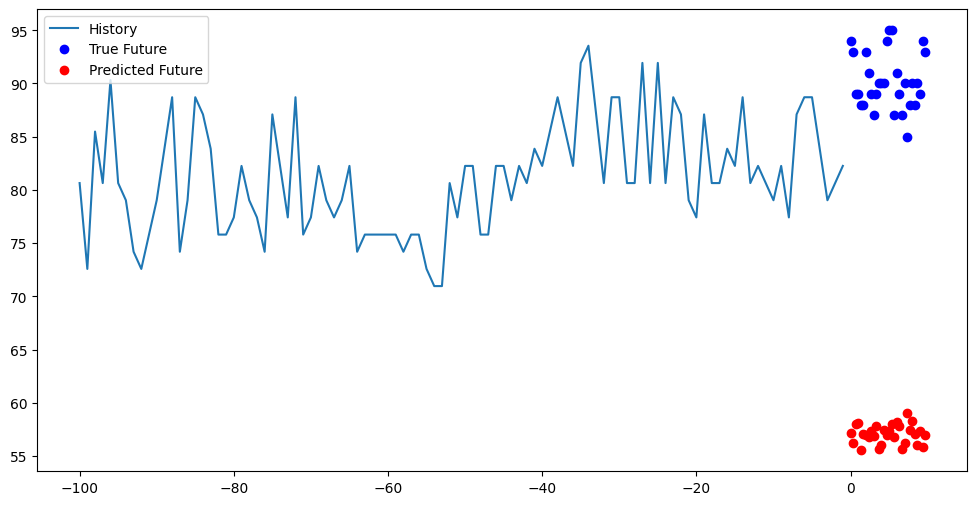

10/10 [==============================] - 1s 66ms/step


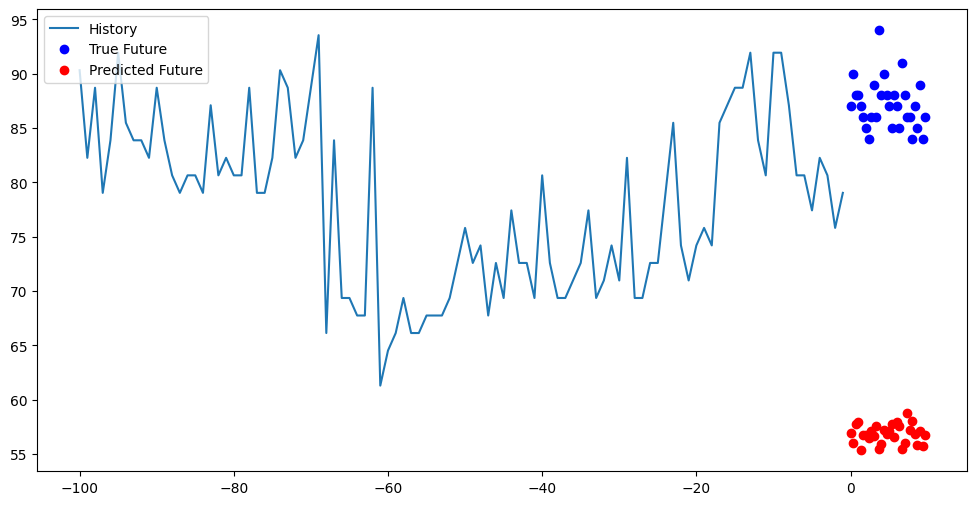

In [94]:
for x, y in val_data_t_cpu.take(6):
  step_plot(x[0], 4,  y[0], model_t_cpu.predict(x)[0])

In [95]:
model_t_cpu.save('Model_Temp_CPU_file usage.h5')
print('Model Saved!')

model_t_cpu.save_weights('Model_Temp_CPU_ffile usage_Weights')
print('Model Saved!')

Model Saved!
Model Saved!


6) Температура диска

In [96]:
x_train, y_train = multivariate_data(X, Y[:, 5], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 5], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_t_disk = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_t_disk = train_data_t_disk.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_t_disk = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_t_disk = val_data_t_disk.batch(BATCH_SIZE).repeat()

In [97]:
model_t_disk = tf.keras.models.Sequential()
model_t_disk.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
model_t_disk.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_t_disk.add(tf.keras.layers.LSTM(32, activation='relu'))
model_t_disk.add(tf.keras.layers.Dropout(0.2))
model_t_disk.add(tf.keras.layers.Dense(32, activation='relu'))
model_t_disk.add(tf.keras.layers.Dropout(0.2))
model_t_disk.add(tf.keras.layers.Dense(30, activation='relu'))
model_t_disk.compile(optimizer='adam', loss='mse', metrics = 'mae')

In [98]:
model_history_t_disk = model_t_disk.fit(train_data_t_disk, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_t_disk,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 71s 1s/step - loss: 2341.6958 - mae: 38.4041 - val_loss: 1917.1630 - val_mae: 43.7816
Epoch 2/25
50/50 [==============================] - 65s 1s/step - loss: 1435.2788 - mae: 37.1479 - val_loss: 1906.7970 - val_mae: 43.6630
Epoch 3/25
50/50 [==============================] - 64s 1s/step - loss: 1099.0453 - mae: 31.2249 - val_loss: 1889.3097 - val_mae: 43.4622
Epoch 4/25
50/50 [==============================] - 59s 1s/step - loss: 588.2643 - mae: 21.3922 - val_loss: 1864.1798 - val_mae: 43.1720
Epoch 5/25
50/50 [==============================] - 66s 1s/step - loss: 402.8199 - mae: 17.0382 - val_loss: 1819.2789 - val_mae: 42.6486
Epoch 6/25
50/50 [==============================] - 64s 1s/step - loss: 277.7367 - mae: 13.6812 - val_loss: 111.6431 - val_mae: 10.3196
Epoch 7/25
50/50 [==============================] - 63s 1s/step - loss: 207.4852 - mae: 11.5055 - val_loss: 153.1855 - val_mae: 12.2433
Epoch 8/25
50/50 [======================

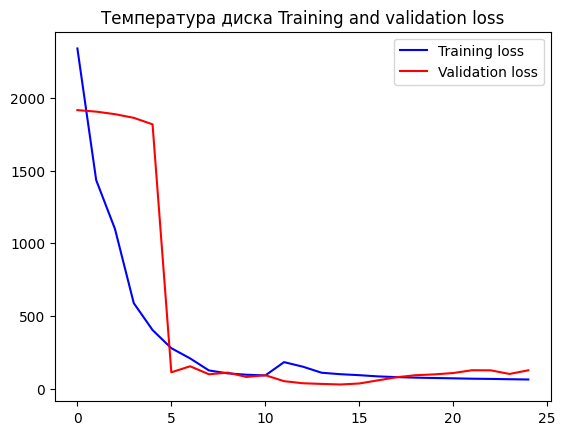

In [99]:
plot_history(model_history_t_disk, 'Температура диска Training and validation loss')

10/10 [==============================] - 2s 74ms/step


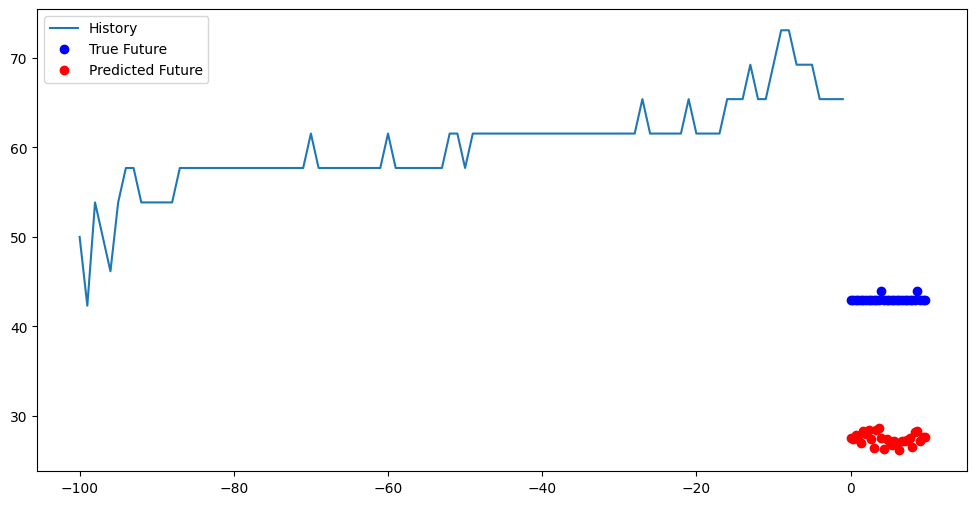

10/10 [==============================] - 1s 63ms/step


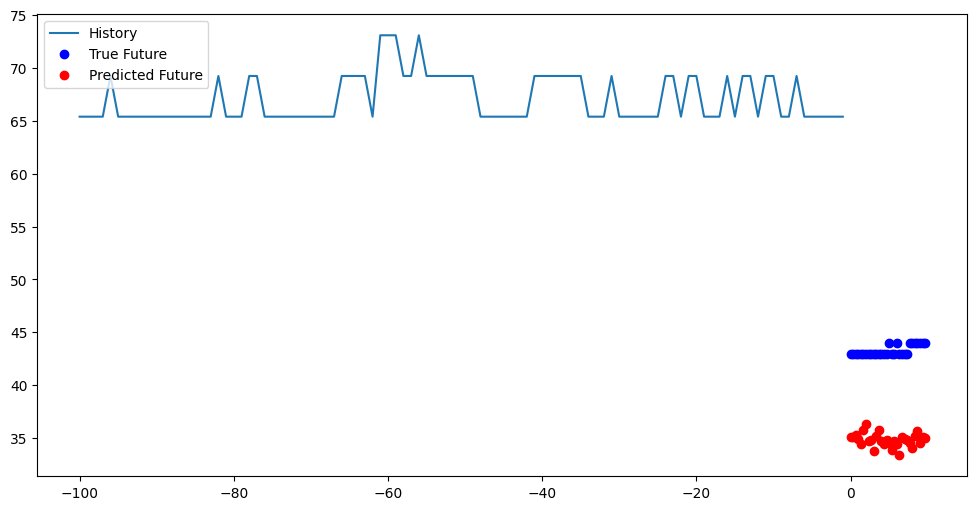

10/10 [==============================] - 1s 59ms/step


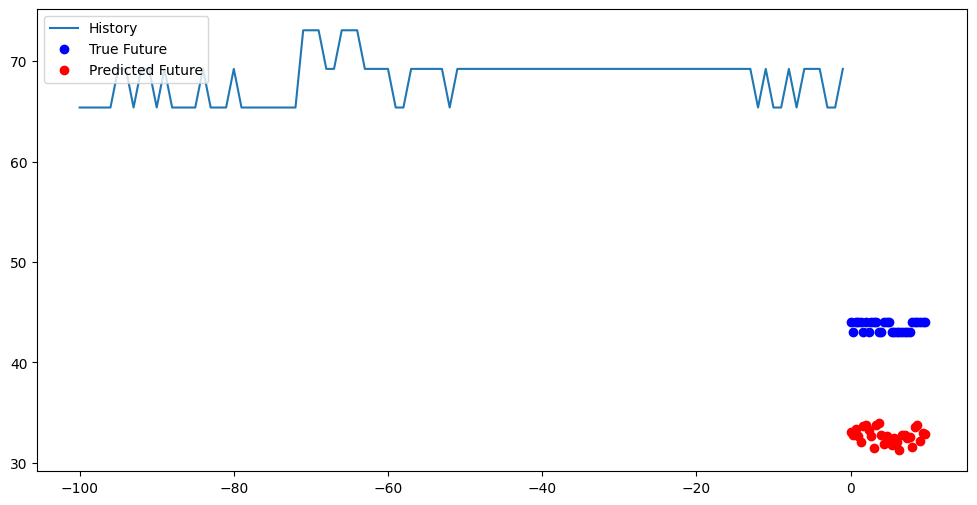

10/10 [==============================] - 1s 112ms/step


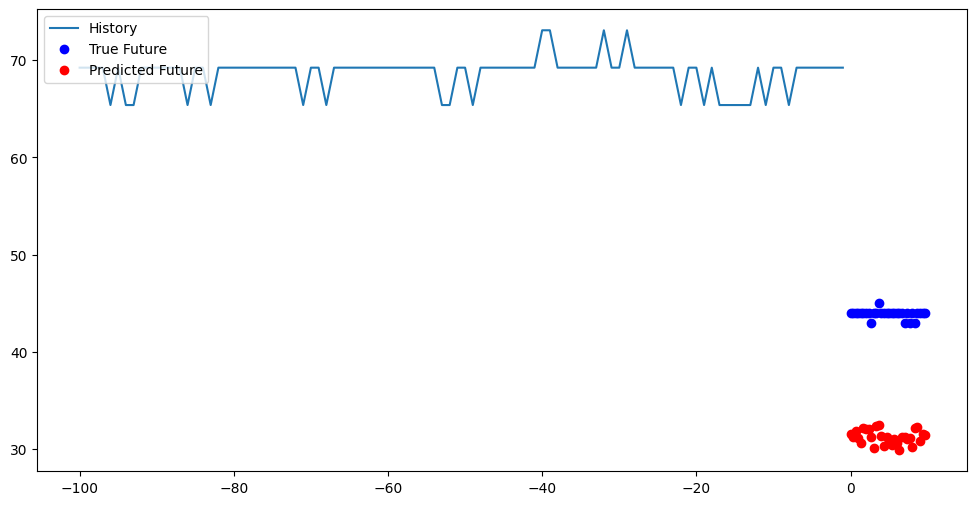

10/10 [==============================] - 1s 110ms/step


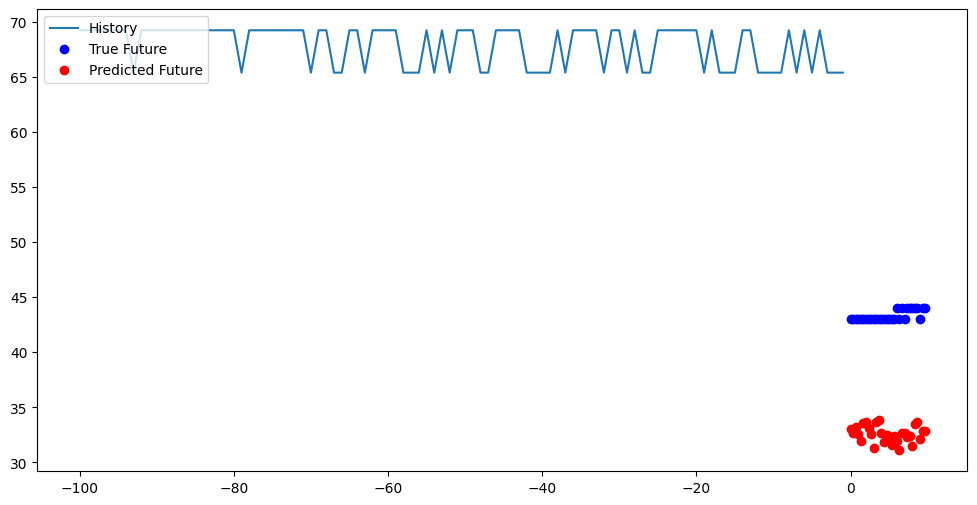

10/10 [==============================] - 1s 64ms/step


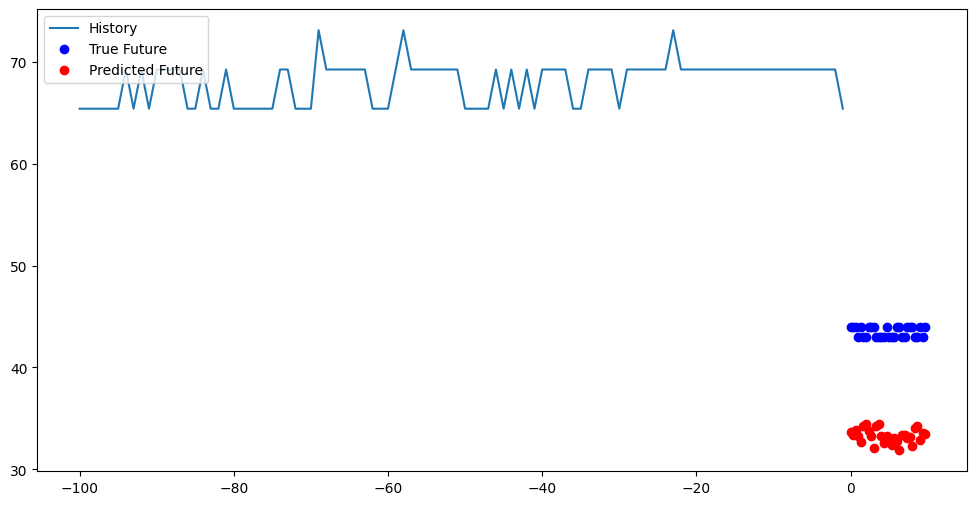

In [100]:
for x, y in val_data_t_disk.take(6):
  step_plot(x[0], 5,  y[0], model_t_disk.predict(x)[0])

In [101]:
model_t_disk.save('Model_Temp_Disk_file usage.h5')
print('Model Saved!')

model_t_disk.save_weights('Model_Temp_Disk_ffile usage_Weights')
print('Model Saved!')

Model Saved!
Model Saved!


7) Общая активность диска

In [102]:
x_train, y_train = multivariate_data(X, Y[:, 6], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 6], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_a_disk = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_a_disk = train_data_a_disk.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_a_disk = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_a_disk = val_data_a_disk.batch(BATCH_SIZE).repeat()

In [103]:
model_a_disk = tf.keras.models.Sequential()
model_a_disk.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
model_a_disk.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_a_disk.add(tf.keras.layers.LSTM(32, activation='relu'))
model_a_disk.add(tf.keras.layers.Dropout(0.2))
model_a_disk.add(tf.keras.layers.Dense(32, activation='relu'))
model_a_disk.add(tf.keras.layers.Dropout(0.2))
model_a_disk.add(tf.keras.layers.Dense(30, activation='relu'))
model_a_disk.compile(optimizer='adam', loss='mse', metrics = 'mae')

In [104]:
model_history_a_disk = model_a_disk.fit(train_data_a_disk, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_a_disk,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 70s 1s/step - loss: 33.7234 - mae: 1.5055 - val_loss: 10.1992 - val_mae: 0.2892
Epoch 2/25
50/50 [==============================] - 64s 1s/step - loss: 25.2216 - mae: 1.4101 - val_loss: 10.2570 - val_mae: 0.5690
Epoch 3/25
50/50 [==============================] - 61s 1s/step - loss: 24.4060 - mae: 1.5277 - val_loss: 10.9661 - val_mae: 1.1793
Epoch 4/25
50/50 [==============================] - 65s 1s/step - loss: 24.0733 - mae: 1.6420 - val_loss: 11.3258 - val_mae: 1.3916
Epoch 5/25
50/50 [==============================] - 64s 1s/step - loss: 25.8649 - mae: 1.5109 - val_loss: 10.2319 - val_mae: 0.6054
Epoch 6/25
50/50 [==============================] - 64s 1s/step - loss: 33.3639 - mae: 1.4446 - val_loss: 10.3305 - val_mae: 0.7353
Epoch 7/25
50/50 [==============================] - 64s 1s/step - loss: 25.3271 - mae: 1.3508 - val_loss: 10.2957 - val_mae: 0.6968
Epoch 8/25
50/50 [==============================] - 61s 1s/step - loss: 25.4

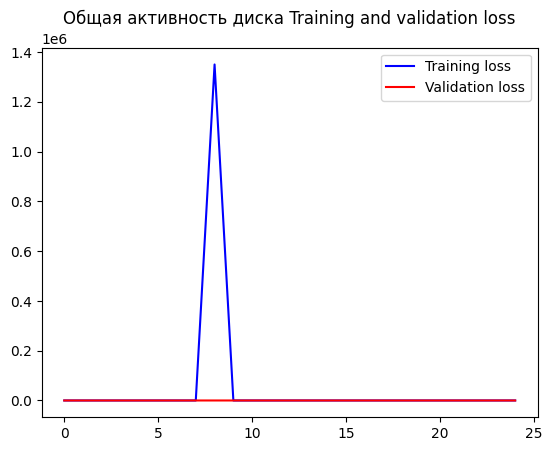

In [105]:
plot_history(model_history_a_disk, 'Общая активность диска Training and validation loss')

10/10 [==============================] - 2s 110ms/step


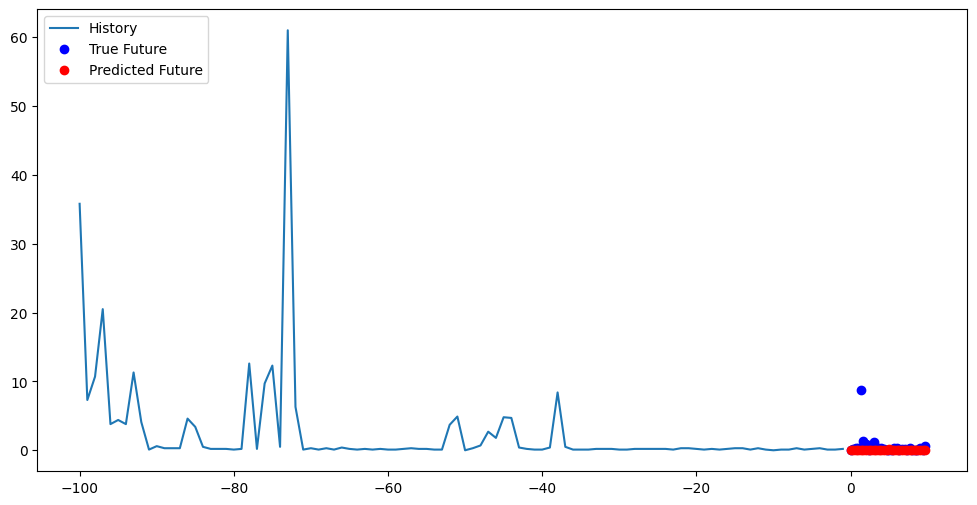

10/10 [==============================] - 1s 59ms/step


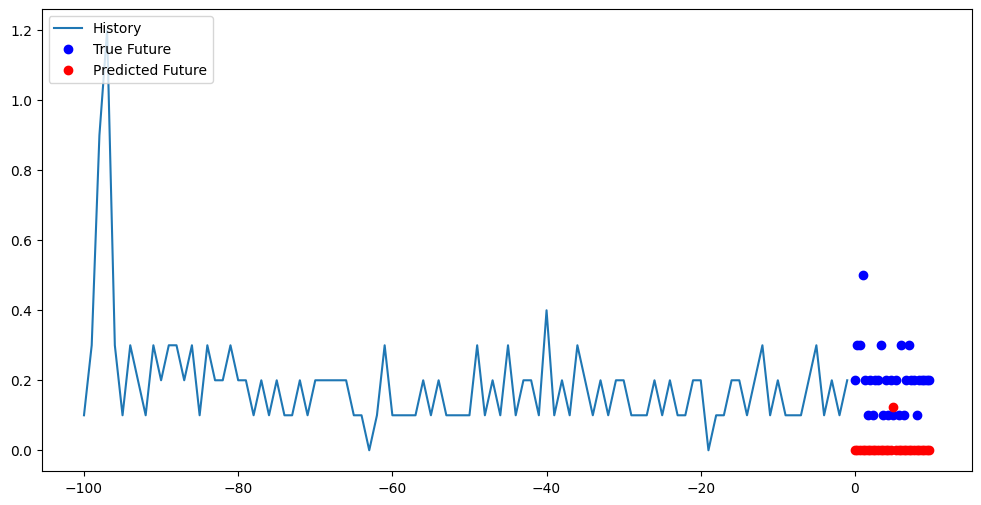

10/10 [==============================] - 1s 61ms/step


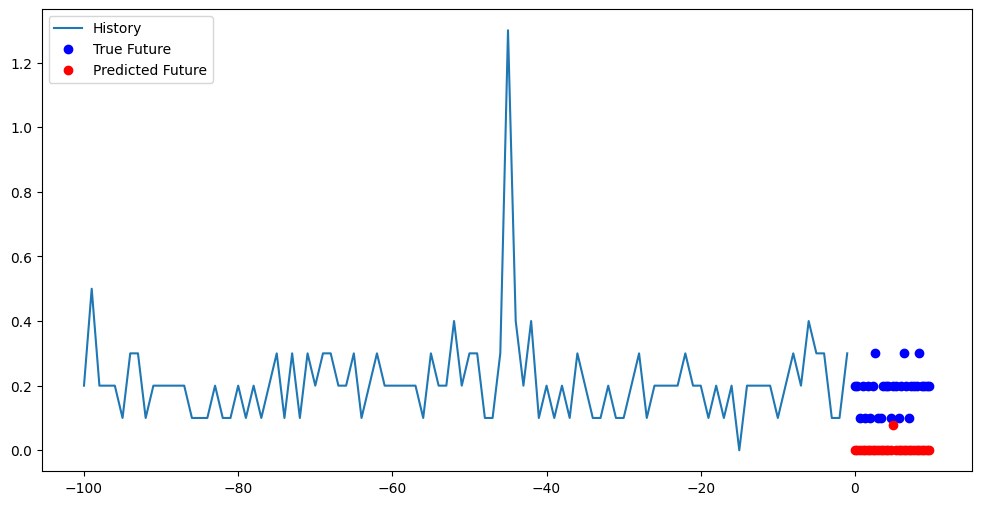

10/10 [==============================] - 1s 62ms/step


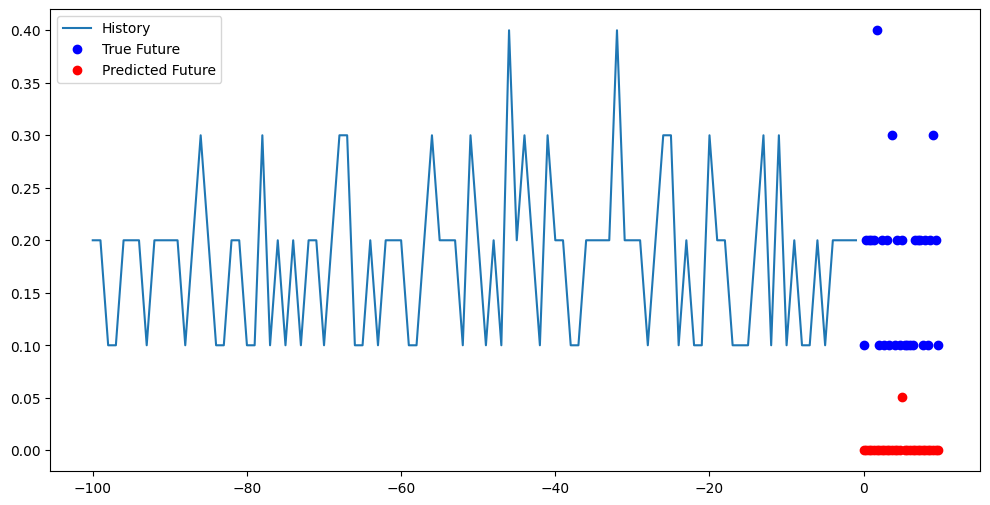

10/10 [==============================] - 1s 61ms/step


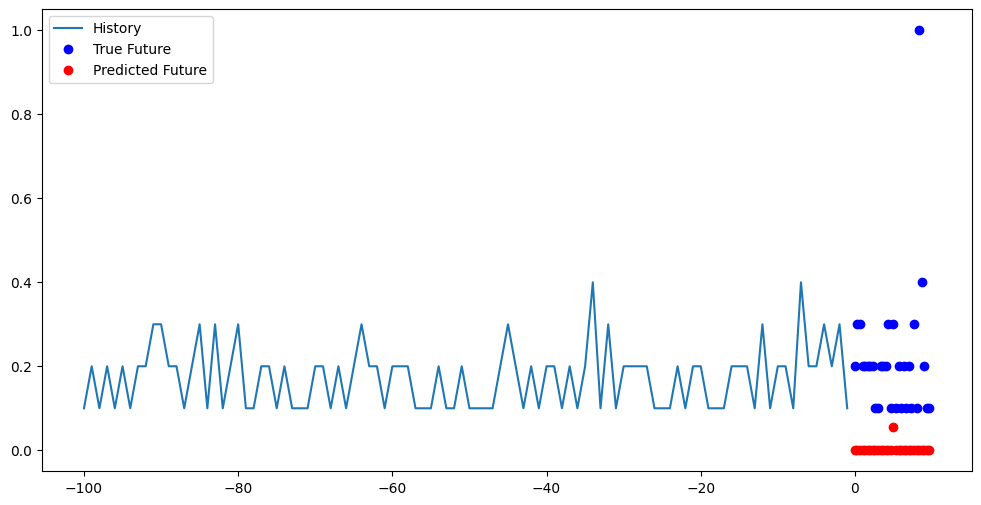

10/10 [==============================] - 1s 65ms/step


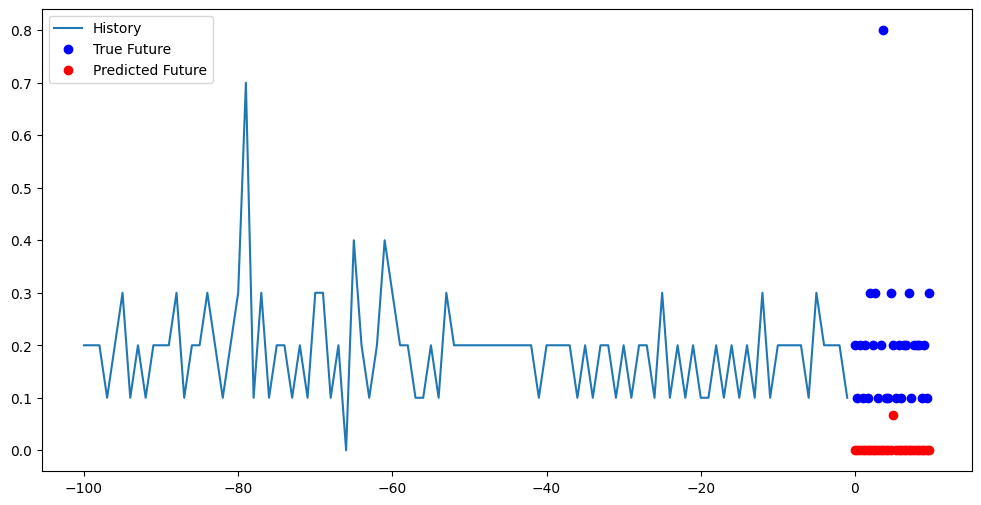

In [106]:
for x, y in val_data_a_disk.take(6):
  step_plot(x[0], 6,  y[0], model_a_disk.predict(x)[0])

In [107]:
model_a_disk.save('Model_Total disk activity_file usage.h5')
print('Model Saved!')

model_a_disk.save_weights('Model_Total disk activity_ffile usage_Weights')
print('Model Saved!')

Model Saved!
Model Saved!


8) Температура GPU

In [108]:
x_train, y_train = multivariate_data(X, Y[:, 7], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 7], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_t_gpu = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_t_gpu = train_data_t_gpu.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_t_gpu = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_t_gpu = val_data_t_gpu.batch(BATCH_SIZE).repeat()

In [109]:
model_t_gpu = tf.keras.models.Sequential()
model_t_gpu.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))

model_t_gpu.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_t_gpu.add(tf.keras.layers.LSTM(32, activation='relu'))
model_t_gpu.add(tf.keras.layers.Dropout(0.2))
model_t_gpu.add(tf.keras.layers.Dense(32, activation='relu'))
model_t_gpu.add(tf.keras.layers.Dropout(0.2))
model_t_gpu.add(tf.keras.layers.Dense(30, activation='relu'))
model_t_gpu.compile(optimizer='adam', loss='mse', metrics = 'mae')

In [110]:
model_history_t_gpu = model_t_gpu.fit(train_data_t_gpu, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_t_gpu,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 70s 1s/step - loss: 360820.1875 - mae: 109.2936 - val_loss: 16777244.0000 - val_mae: 2022.3351
Epoch 2/25
50/50 [==============================] - 65s 1s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/25
50/50 [==============================] - 61s 1s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/25
50/50 [==============================] - 66s 1s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/25
50/50 [==============================] - 61s 1s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/25
50/50 [==============================] - 64s 1s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/25
50/50 [==============================] - 65s 1s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/25
50/50 [==============================] - 63s 1s/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/25
50/50 [=========

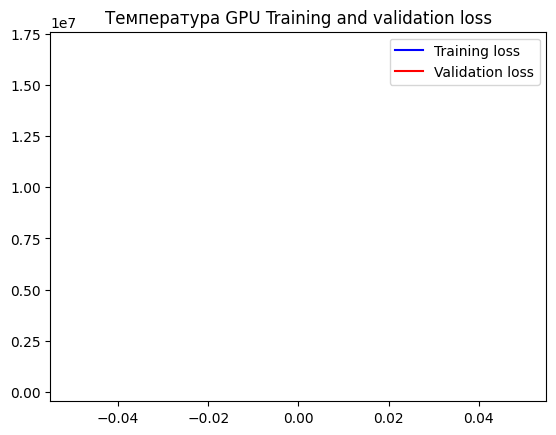

In [111]:
plot_history(model_history_t_gpu, 'Температура GPU Training and validation loss')

10/10 [==============================] - 2s 61ms/step


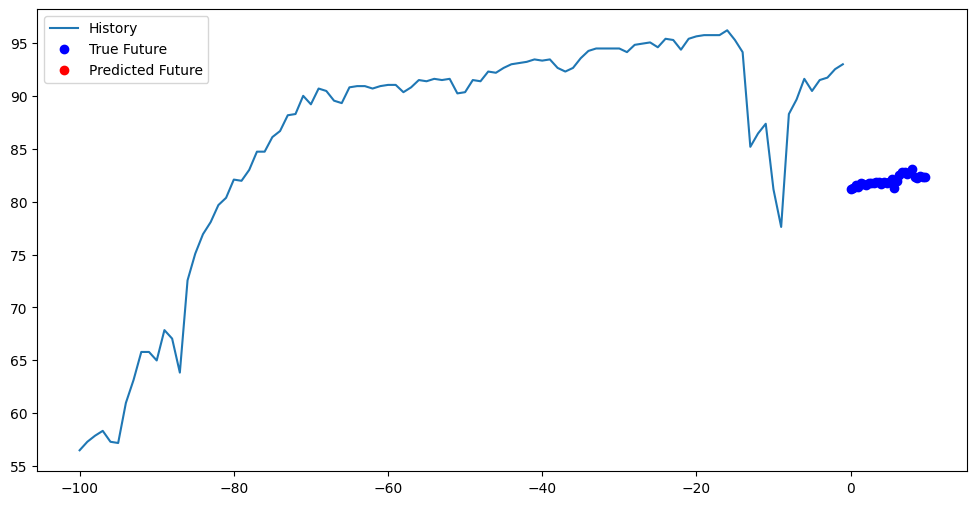

10/10 [==============================] - 1s 61ms/step


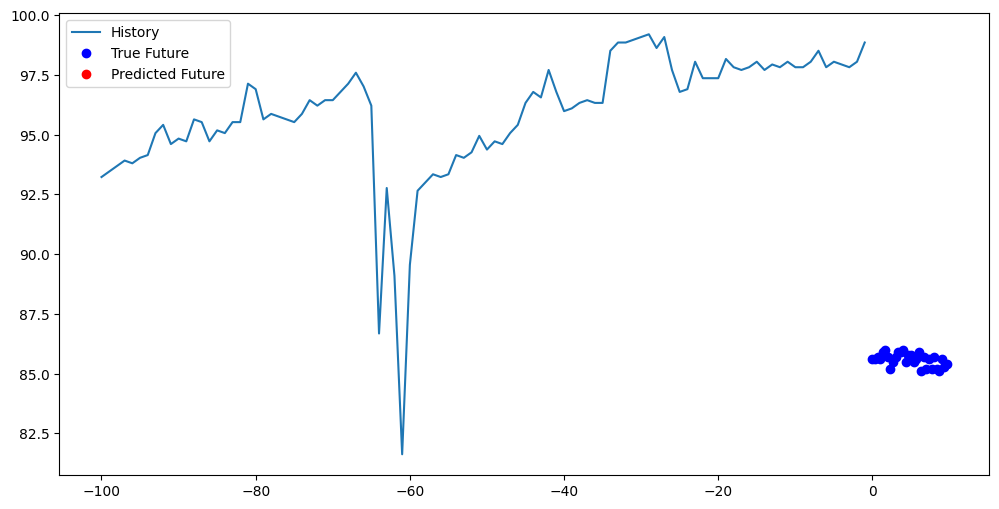

10/10 [==============================] - 1s 60ms/step


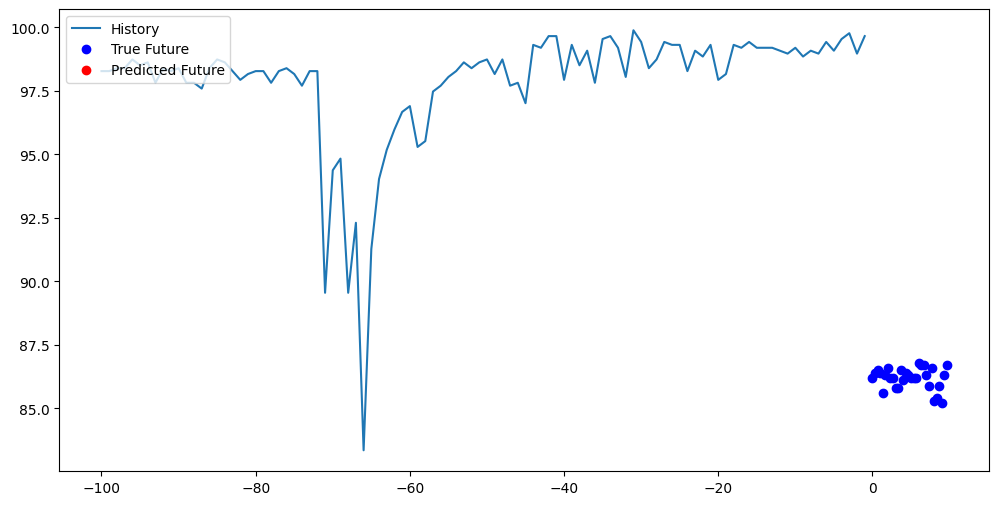

10/10 [==============================] - 1s 61ms/step


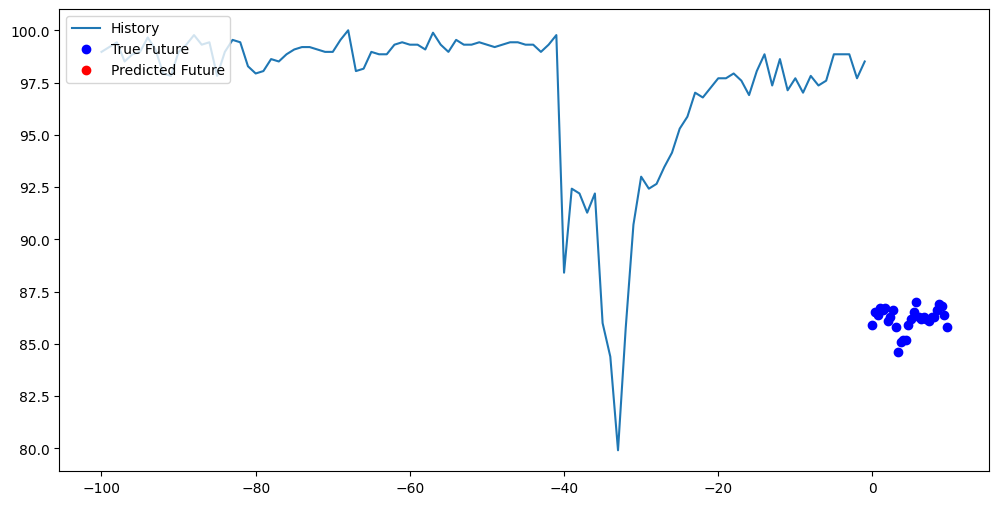

10/10 [==============================] - 1s 63ms/step


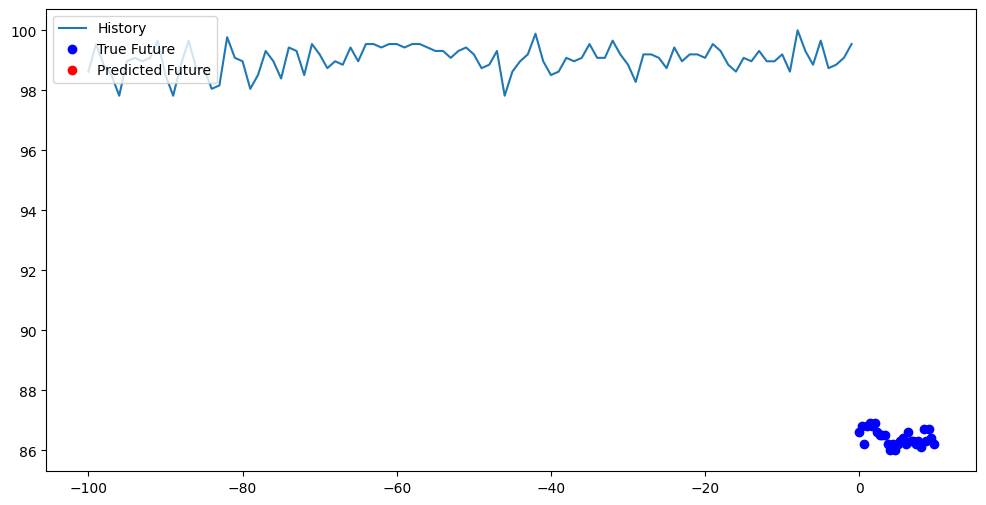

10/10 [==============================] - 1s 62ms/step


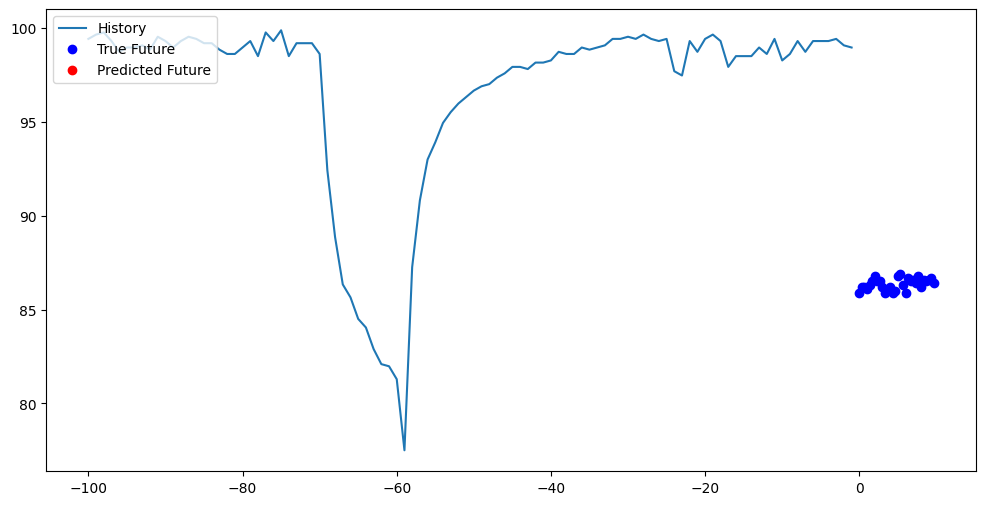

In [112]:
for x, y in val_data_t_gpu.take(6):
  step_plot(x[0], 7,  y[0], model_t_gpu.predict(x)[0])

In [113]:
model_t_gpu.save('Model_GPU temp_file usage.h5')
print('Model Saved!')

model_t_gpu.save_weights('Model_GPU temp_ffile usage_Weights')
print('Model Saved!')

Model Saved!
Model Saved!


9) Нагрузка на ядро GPU

In [114]:
x_train, y_train = multivariate_data(X, Y[:, 8], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 8], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_n_gpu = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_n_gpu = train_data_n_gpu.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_n_gpu = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_n_gpu = val_data_n_gpu.batch(BATCH_SIZE).repeat()

In [115]:
model_n_gpu = tf.keras.models.Sequential()
model_n_gpu.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))

model_n_gpu.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_n_gpu.add(tf.keras.layers.LSTM(32, activation='relu'))
model_n_gpu.add(tf.keras.layers.Dropout(0.2))
model_n_gpu.add(tf.keras.layers.Dense(32, activation='relu'))
model_n_gpu.add(tf.keras.layers.Dropout(0.2))
model_n_gpu.add(tf.keras.layers.Dense(30, activation='relu'))
model_n_gpu.compile(optimizer='adam', loss='mse', metrics = 'mae')

In [116]:
model_history_n_gpu = model_n_gpu.fit(train_data_n_gpu, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_n_gpu,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 74s 1s/step - loss: 1937.8845 - mae: 29.4252 - val_loss: 5541.5137 - val_mae: 70.4213
Epoch 2/25
50/50 [==============================] - 64s 1s/step - loss: 1707.1697 - mae: 28.4339 - val_loss: 4558.1353 - val_mae: 63.9748
Epoch 3/25
50/50 [==============================] - 60s 1s/step - loss: 1189.8545 - mae: 25.4493 - val_loss: 3351.1055 - val_mae: 55.4208
Epoch 4/25
50/50 [==============================] - 66s 1s/step - loss: 1124.2300 - mae: 24.9351 - val_loss: 2871.5813 - val_mae: 51.6922
Epoch 5/25
50/50 [==============================] - 64s 1s/step - loss: 998.6956 - mae: 23.1921 - val_loss: 2652.6387 - val_mae: 49.8196
Epoch 6/25
50/50 [==============================] - 59s 1s/step - loss: 994.7929 - mae: 22.9028 - val_loss: 2704.3406 - val_mae: 50.2097
Epoch 7/25
50/50 [==============================] - 65s 1s/step - loss: 938.4470 - mae: 22.0418 - val_loss: 2702.7571 - val_mae: 50.2196
Epoch 8/25
50/50 [===================

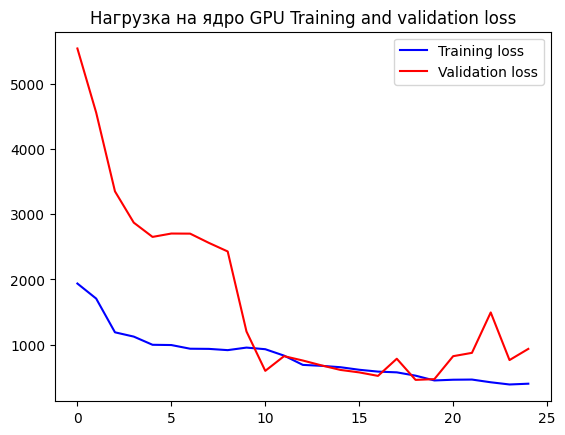

In [117]:
plot_history(model_history_n_gpu, 'Нагрузка на ядро GPU Training and validation loss')

10/10 [==============================] - 3s 112ms/step


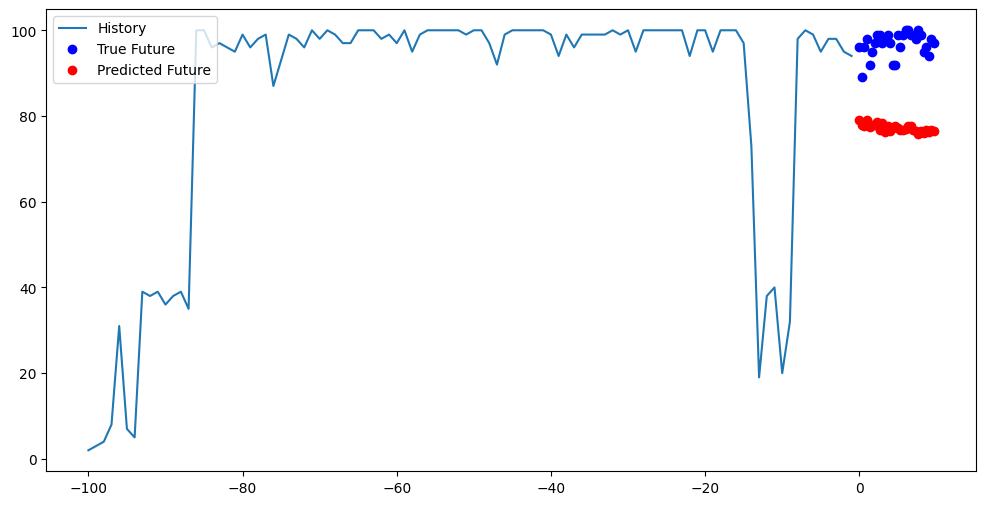

10/10 [==============================] - 1s 62ms/step


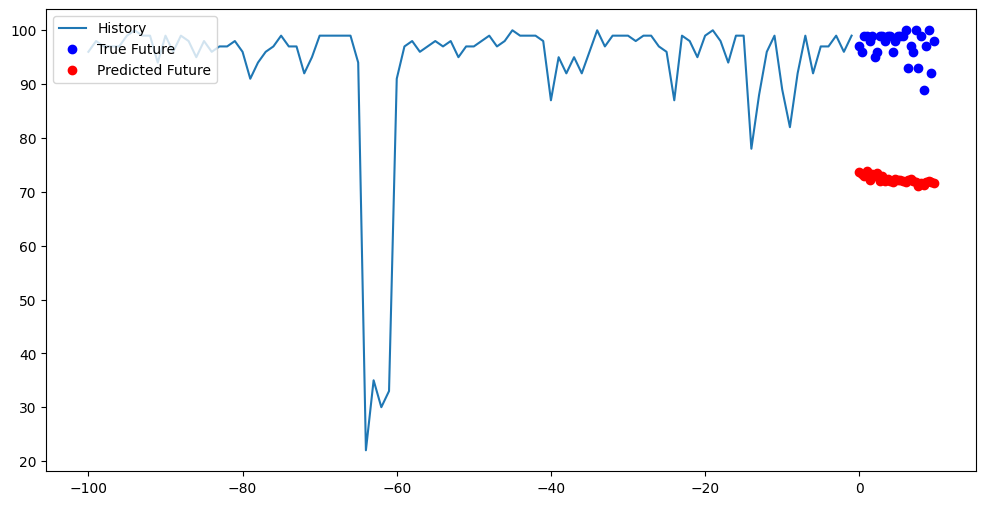

10/10 [==============================] - 1s 64ms/step


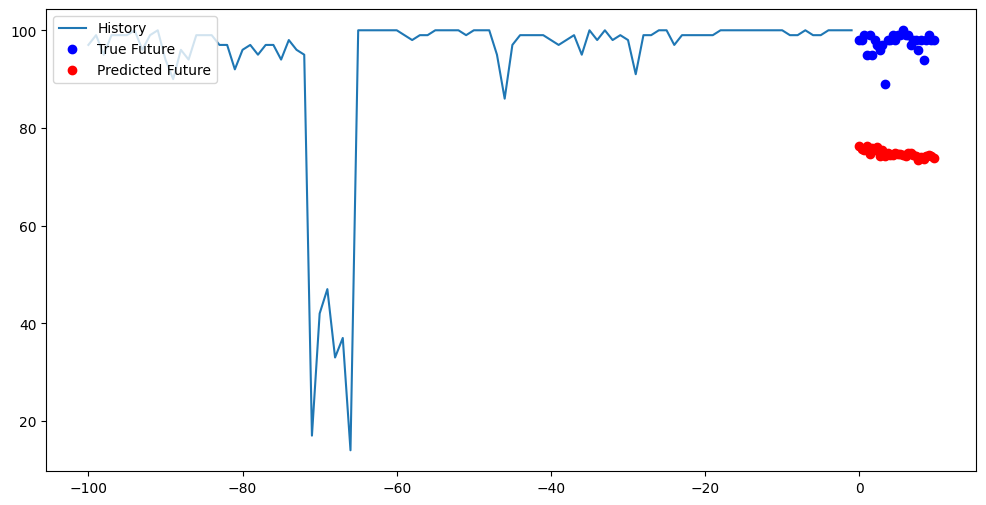

10/10 [==============================] - 1s 66ms/step


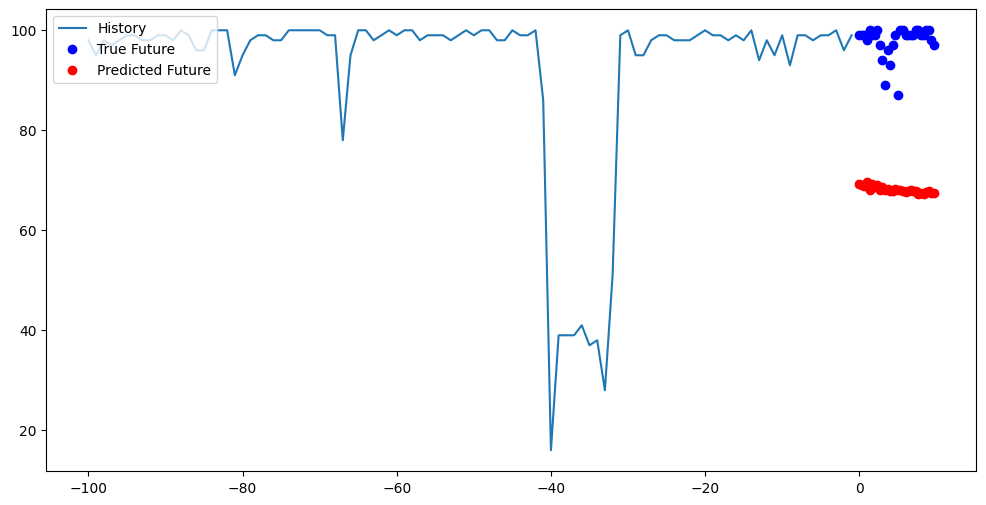

10/10 [==============================] - 1s 63ms/step


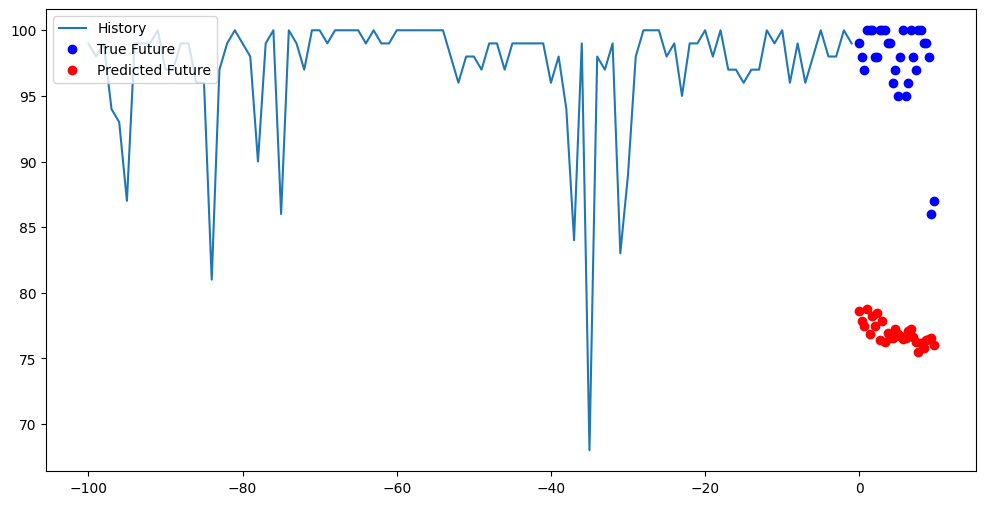

10/10 [==============================] - 1s 64ms/step


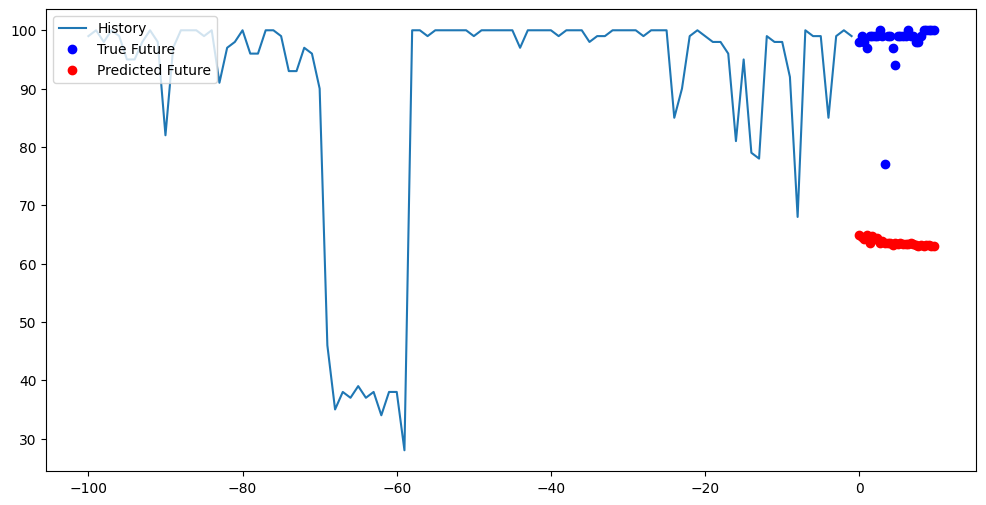

In [118]:
for x, y in val_data_n_gpu.take(6):
  step_plot(x[0], 8,  y[0], model_n_gpu.predict(x)[0])

In [119]:
model_n_gpu.save('Model_GPU core load_file usage.h5')
print('Model Saved!')

model_n_gpu.save_weights('Model_GPU core load_ffile usage_Weights')
print('Model Saved!')

Model Saved!
Model Saved!


10) Использование памяти GPU

In [120]:
x_train, y_train = multivariate_data(X, Y[:, 9], 0, TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(X, Y[:, 9], TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_d_gpu = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_d_gpu = train_data_d_gpu.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_d_gpu = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_d_gpu = val_data_d_gpu.batch(BATCH_SIZE).repeat()

In [121]:
model_d_gpu = tf.keras.models.Sequential()
model_d_gpu.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
model_d_gpu.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_d_gpu.add(tf.keras.layers.LSTM(32, activation='relu'))
model_d_gpu.add(tf.keras.layers.Dropout(0.2))
model_d_gpu.add(tf.keras.layers.Dense(30, activation='relu'))
model_d_gpu.add(tf.keras.layers.Dropout(0.2))
model_d_gpu.add(tf.keras.layers.Dense(30, activation='relu'))
model_d_gpu.compile(optimizer='adam', loss='mse', metrics = 'mae')

In [122]:
model_history_d_gpu = model_d_gpu.fit(train_data_d_gpu, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_d_gpu,
                                          validation_steps=50)

Epoch 1/25
50/50 [==============================] - 67s 1s/step - loss: 301.0486 - mae: 9.8675 - val_loss: 0.3670 - val_mae: 0.5958
Epoch 2/25
50/50 [==============================] - 66s 1s/step - loss: 218.6618 - mae: 9.2179 - val_loss: 0.2830 - val_mae: 0.5103
Epoch 3/25
50/50 [==============================] - 64s 1s/step - loss: 214.8568 - mae: 9.0376 - val_loss: 0.1977 - val_mae: 0.3908
Epoch 4/25
50/50 [==============================] - 64s 1s/step - loss: 213.5414 - mae: 8.9846 - val_loss: 0.1474 - val_mae: 0.3126
Epoch 5/25
50/50 [==============================] - 66s 1s/step - loss: 204.6039 - mae: 8.6369 - val_loss: 0.2865 - val_mae: 0.4193
Epoch 6/25
50/50 [==============================] - 61s 1s/step - loss: 204.8112 - mae: 8.3557 - val_loss: 0.9124 - val_mae: 0.7453
Epoch 7/25
50/50 [==============================] - 59s 1s/step - loss: 195.5702 - mae: 7.9356 - val_loss: 2.4491 - val_mae: 1.3021
Epoch 8/25
50/50 [==============================] - 64s 1s/step - loss: 183.

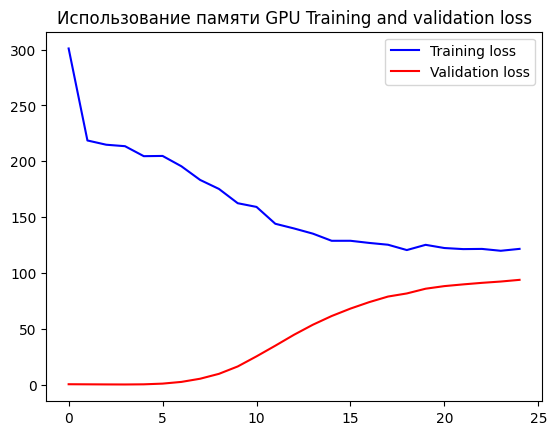

In [123]:
plot_history(model_history_d_gpu, 'Использование памяти GPU Training and validation loss')

10/10 [==============================] - 2s 73ms/step


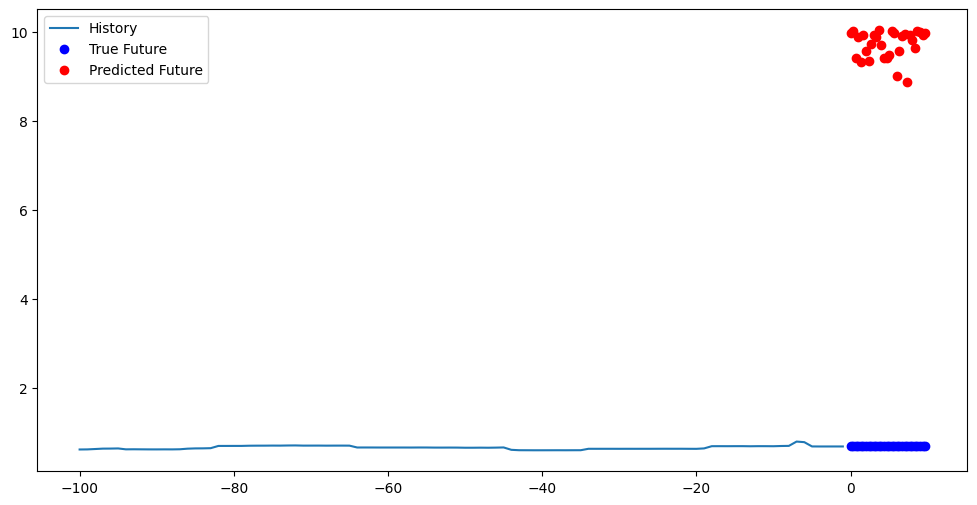

10/10 [==============================] - 1s 62ms/step


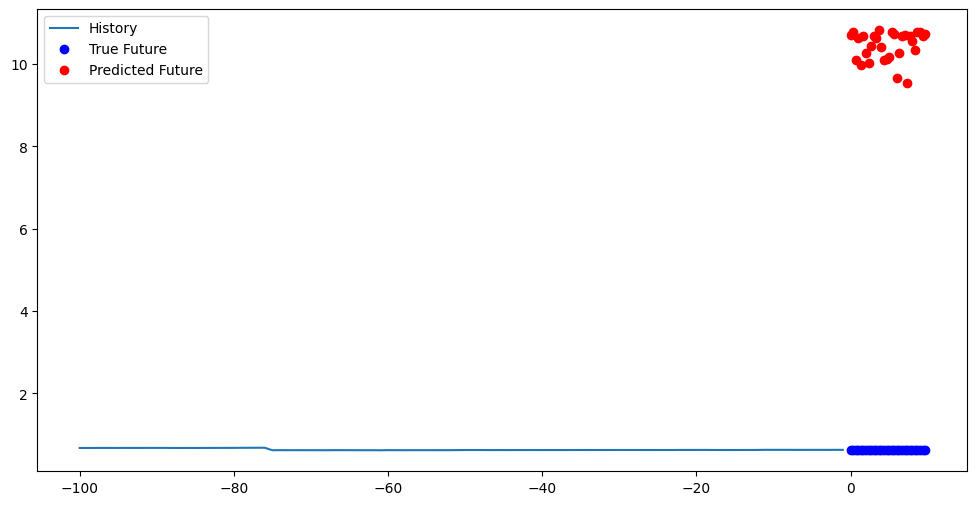

10/10 [==============================] - 1s 60ms/step


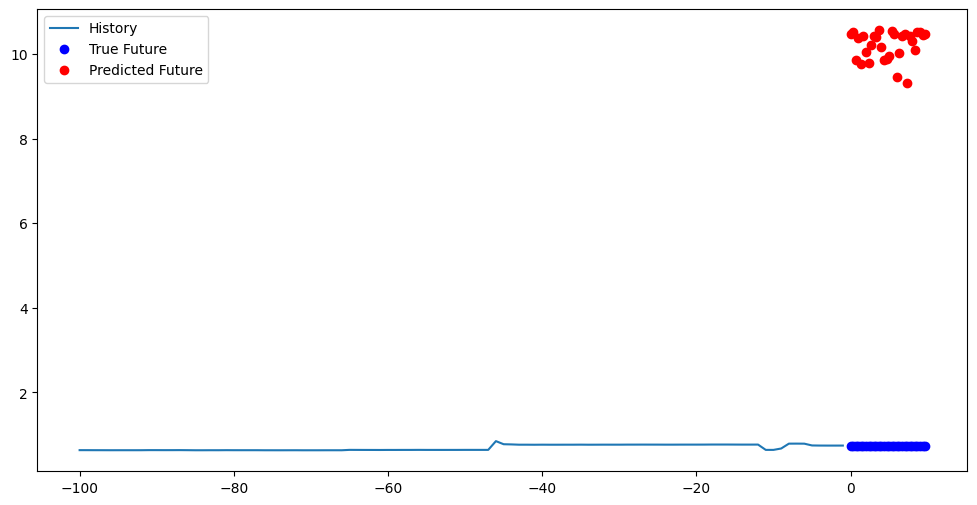

10/10 [==============================] - 1s 61ms/step


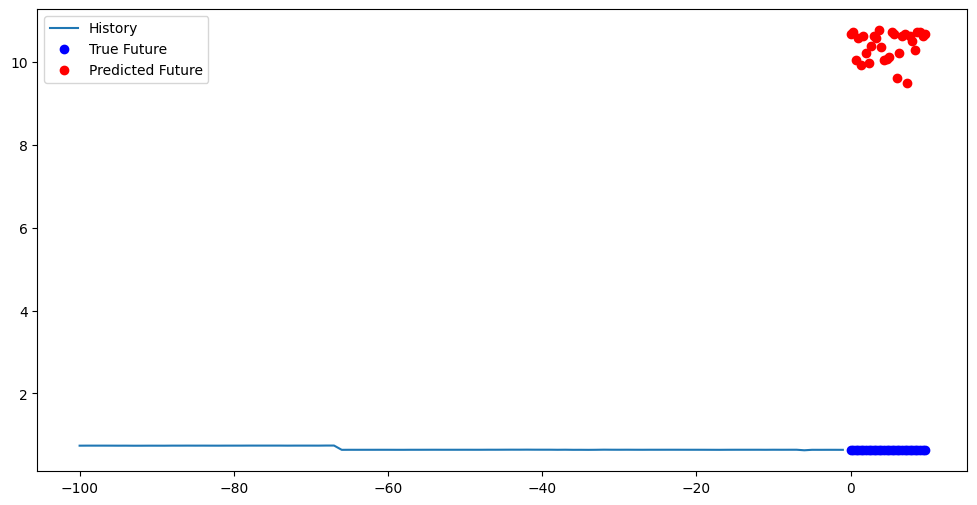

10/10 [==============================] - 1s 63ms/step


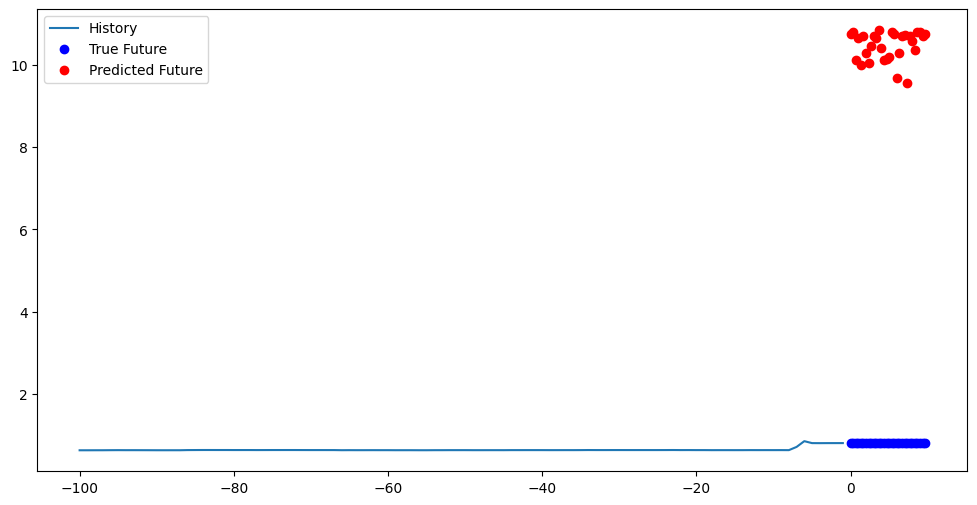

10/10 [==============================] - 1s 60ms/step


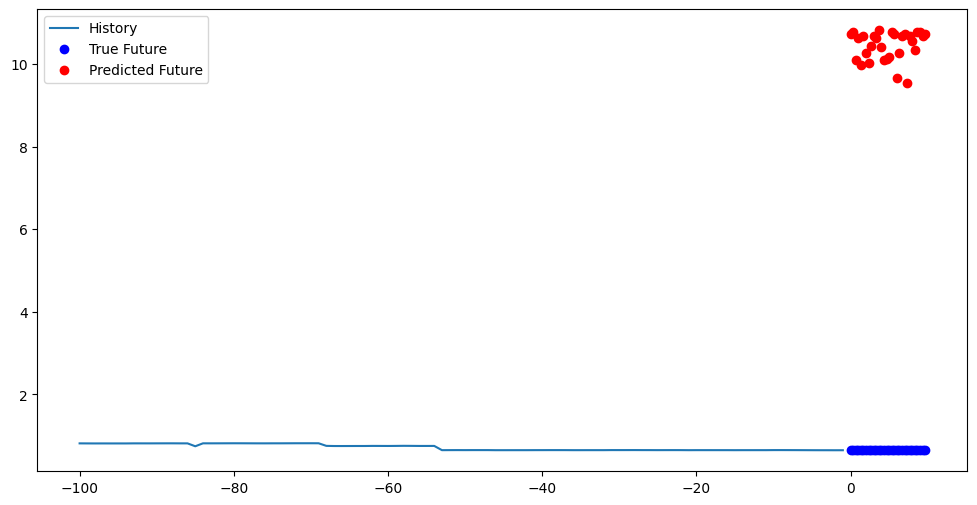

In [124]:
for x, y in val_data_d_gpu.take(6):
  step_plot(x[0], 9,  y[0], model_d_gpu.predict(x)[0])

In [125]:
model_d_gpu.save('Model_GPU memory_file usage.h5')
print('Model Saved!')

model_d_gpu.save_weights('Model_GPU memory_ffile usage_Weights')
print('Model Saved!')

Model Saved!
Model Saved!


In [126]:
features = ['Загрузка виртуальной памяти [%]', 'Физическая нагрузка на память [%]', 'Использование файла подкачки [%]', 'Общая загрузка ЦП [%].1', 'CPU [°C]',
            'Температура диска [°C]', 'Общая активность диска [%].1', 'Температура GPU [°C]', 'Нагрузка на ядро GPU [%]', 'Использование памяти GPU [%]']

In [127]:
from google.colab import files
files.download('Model_CPU_load_file usage.h5')

files.download('Model_CPU_load_file usage_Weights.data-00000-of-00001')

files.download('Model_CPU_load_file usage_Weights.index')

files.download('Model_GPU core load_ffile usage_Weights.data-00000-of-00001')

files.download('Model_GPU core load_ffile usage_Weights.index')

files.download('Model_GPU core load_file usage.h5')

files.download('Model_GPU memory_ffile usage_Weights.data-00000-of-00001')

files.download('Model_GPU memory_ffile usage_Weights.index')

files.download('Model_GPU memory_file usage.h5')

files.download('Model_GPU temp_ffile usage_Weights.data-00000-of-00001')

files.download('Model_GPU temp_ffile usage_Weights.index')

files.download('Model_GPU temp_file usage.h5')

files.download('Model_Swap file usage.h5')

files.download('Model_Swap file usage_Weights.data-00000-of-00001')

files.download('Model_Swap file usage_Weights.index')

files.download('Model_Temp_CPU_ffile usage_Weights.data-00000-of-00001')

files.download('Model_Temp_CPU_ffile usage_Weights.index')

files.download('Model_Temp_CPU_file usage.h5')

files.download('Model_Temp_Disk_ffile usage_Weights.data-00000-of-00001')

files.download('Model_Temp_Disk_ffile usage_Weights.index')

files.download('Model_Temp_Disk_file usage.h5')

files.download('Model_Total disk activity_ffile usage_Weights.data-00000-of-00001')

files.download('Model_Total disk activity_ffile usage_Weights.index')

files.download('Model_Total disk activity_file usage.h5')

files.download('Model_load on memory.h5')

files.download('Model_load on memory_Weights.data-00000-of-00001')

files.download('Model_load on memory_Weights.index')

files.download('Model_memory_recovery.h5')

files.download('Model_memory_recovery_Weights.data-00000-of-00001')

files.download('Model_memory_recovery_Weights.index')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>